<div style="display: flex; ">
    <h1 style="margin: auto; font-weight: bold; color: black; padding: 30px 30px 0px 30px;" align="center"> Anticipez les besoins en consommation de bâtiments </h1>
</div>

<div style="display: flex; margin: auto; padding: 5px 30px 0px 30px;" > <h2 style="width: 100%; text-align: center; color: black; float: left;" align="center">Notebook exploration : 
Prédire la consommation totale d’énergie des bâtiments.
</h2> 
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Importations librairies, fonctions, fichiers </h3>
</div>

In [1021]:
##Importation des librairies
import os
import io
import re
import gc
import itertools
import math
import pandas as pd
import numpy as np
import ppscore as pps
import unidecode as un
import seaborn as sns
import missingno as msno
import plotly as pl
import plotly.express as px
import datetime as dt
import functools
import scipy.stats as stats
import statsmodels.api as sm
import pyarrow.parquet as pq
import time as time
import category_encoders as ce
%matplotlib inline
from math import prod
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.graphics.gofplots import qqplot
from mlxtend.plotting import plot_pca_correlation_graph
from scipy.stats import shapiro, normaltest, anderson, pearsonr, spearmanr, kendalltau
from sklearn.decomposition import PCA
from sklearn import neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.svm import LinearSVC, SVR
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit
from sklearn.linear_model import LassoCV, BayesianRidge, LinearRegression,  LogisticRegression, Lasso
from ydata_profiling import ProfileReport
from collections import Counter
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.utils.validation import check_is_fitted
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error, r2_score, RocCurveDisplay, roc_auc_score, confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import *
from sklearn.pipeline import *

In [1022]:
def plot_features_importance(estimator, name_model, X_train, y_train, scoring=None):
    """
    Generate 1 plots: 
        1. The importance by feature
    
    Parameters
    -----------------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.
        
    name_model : str
        Name of the model as title for the chart.     
        
    X_train : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y_train : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning. 
        
    scoring : string, callable or None, default=None
        Scorer to use. It can be a single string or a callable. 
        If None, the estimator’s default scorer is used. 
        
    Returns:
    -----------------
        None. 
        Plot the graph. 
        
    """     
    # Get the importance by feature
    results = permutation_importance(estimator, X_train, y_train, scoring=scoring)
    
    # Making a dataframe to work easily
    df_importance = pd.DataFrame({
                        "Feature" : X_train.columns,
                        "Importance" : results.importances_mean
                    })
    
    # Sorting by importance before plotting
    df_importance = df_importance.sort_values("Importance")
    
    # Initializing figure    
    fig = plt.subplots(figsize=(10, 8))
    
    plot = sns.barplot(data=df_importance, y=df_importance["Feature"], x=df_importance["Importance"])
    
    plt.title(name_model + " Features Importance", fontdict={ "fontsize": 16, "fontweight": "normal" })
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig("img/" + name_model + "-feature-importance.png")
    plt.show()

In [1023]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

In [1024]:
df = pd.read_parquet('2016_Building_Energy_Benchmarking_cleaned.parquet')

In [1025]:
#df = df.drop(columns = ["ENERGYSTARScore"])

In [1026]:
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [1027]:
df.columns

Index(['OSEBuildingID', 'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'NumberofBuildings', 'BuildingType', 'NumberofFloors', 'BuildingAge',
       'LargestPropertyUseType', 'PrimaryPropertyType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'MeanGFAperFloor', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'MainEnergy', 'TotalGHGEmissions',
       'SiteEnergyUseWN(kBtu)'],
      dtype='object')

In [1028]:
df.isna().sum().sum()

0

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Data preprocessing </h3>
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Encodage des features </h3>
</div>

In [1029]:
df_X = df.copy()

In [1030]:
df_y = df['SiteEnergyUseWN(kBtu)'] # 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'

In [1031]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ENERGYSTARScore'] 
prop_C_cols = ['Neighborhood', 'CouncilDistrictCode','BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'MainEnergy']
faible_card = ["BuildingType", "MainEnergy"]
fort_card = ["Neighborhood", "CouncilDistrictCode","PrimaryPropertyType","LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [1032]:
df_X[prop_C_cols].nunique()

Neighborhood                    13
CouncilDistrictCode              7
BuildingType                     4
PrimaryPropertyType             18
LargestPropertyUseType          20
SecondLargestPropertyUseType    32
ThirdLargestPropertyUseType     31
MainEnergy                       3
dtype: int64

In [1033]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [1034]:
df_one_hot =  df_X[faible_card]
df_one_hot 

,BuildingType,MainEnergy
0,NonResidential,Electricity
1,NonResidential,NaturalGas
2,NonResidential,Electricity
3,NonResidential,Electricity
4,NonResidential,NaturalGas
...,...,...
3339,NonResidential,NaturalGas
3347,NonResidential,Electricity
3366,Nonresidential COS,Electricity
3369,Nonresidential COS,Electricity


In [1035]:
encoder = OneHotEncoder(sparse_output=True)
encoder.fit_transform(df_one_hot)

<1049x7 sparse matrix of type '<class 'numpy.float64'>'
	with 2098 stored elements in Compressed Sparse Row format>

In [1036]:
# One-hot encode the buildingtype
one_hot_type = pd.get_dummies(df_one_hot.BuildingType)
one_hot_type.head()

,Campus,NonResidential,Nonresidential COS,SPS-District K-12
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [1037]:
# One-hot encode the MainEnergy 
one_hot_MainEnergy = pd.get_dummies(df_one_hot.MainEnergy)
one_hot_MainEnergy

,Electricity,NaturalGas,Steam
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
3339,0,1,0
3347,1,0,0
3366,1,0,0
3369,1,0,0


In [1038]:
# Join one-hot-encoded region back to the data
df_X_encod = one_hot_type.join(one_hot_MainEnergy)
df_X_encod.head()

,Campus,NonResidential,Nonresidential COS,SPS-District K-12,Electricity,NaturalGas,Steam
0,0,1,0,0,1,0,0
1,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0
3,0,1,0,0,1,0,0
4,0,1,0,0,0,1,0


In [1039]:
df_X_encod.shape

(1049, 7)

In [1040]:
df_label = df_X[fort_card]

In [1041]:
df_label

,Neighborhood,CouncilDistrictCode,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,DOWNTOWN,7,Hotel,Hotel,None,None
1,DOWNTOWN,7,Hotel,Hotel,Parking,Restaurant
2,DOWNTOWN,7,Hotel,Hotel,None,None
3,DOWNTOWN,7,Hotel,Hotel,None,None
4,DOWNTOWN,7,Hotel,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...
3339,GREATER DUWAMISH,2,Small- and Mid-Sized Office,Office,None,None
3347,GREATER DUWAMISH,3,K-12 School,K-12 School,Parking,None
3366,MAGNOLIA / QUEEN ANNE,7,Office,Office,None,None
3369,SOUTHEAST,2,Office,Office,None,None


In [1042]:
labelencoder = LabelEncoder()
for col in df_label.columns:
    df_label[col] = labelencoder.fit_transform(df_label[col])

C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\1731335012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label[col] = labelencoder.fit_transform(df_label[col])
C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\1731335012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label[col] = labelencoder.fit_transform(df_label[col])
C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\1731335012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [1043]:
df_label

,Neighborhood,CouncilDistrictCode,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,3,6,2,6,15,12
1,3,6,2,6,23,26
2,3,6,2,6,15,12
3,3,6,2,6,15,12
4,3,6,2,6,23,29
...,...,...,...,...,...,...
3339,5,1,14,11,15,12
3347,5,2,3,7,23,12
3366,7,6,8,11,15,12
3369,11,1,8,11,15,12


In [1044]:
# Join one-hot-encoded region back to the data
df_ok = df_X_encod.join(df_label)

In [1045]:
df_X_ok = df_ok.join(df_X[prop_Q_cols])
df_X_ok

,Campus,NonResidential,Nonresidential COS,SPS-District K-12,Electricity,NaturalGas,Steam,Neighborhood,CouncilDistrictCode,PrimaryPropertyType,...,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,BuildingAge,MeanGFAperFloor,ENERGYSTARScore
0,0,1,0,0,1,0,0,3,6,2,...,12,88434,0,88434,88434.00,0.00,0.00,89,6802.62,60.00
1,0,1,0,0,0,1,0,3,6,2,...,11,103566,15064,88502,83880.00,15064.00,4622.00,20,7375.17,61.00
2,0,1,0,0,1,0,0,3,6,2,...,41,956110,196718,759392,756493.00,0.00,0.00,47,18080.76,43.00
3,0,1,0,0,1,0,0,3,6,2,...,10,61320,0,61320,61320.00,0.00,0.00,90,5574.55,56.00
4,0,1,0,0,0,1,0,3,6,2,...,18,175580,62000,113580,123445.00,68009.00,0.00,36,5977.89,75.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,0,1,0,0,0,1,0,5,1,14,...,2,24990,0,24990,24990.00,0.00,0.00,87,8330.00,9.00
3347,0,1,0,0,1,0,0,5,2,3,...,3,45000,0,45000,45728.00,0.00,0.00,1,11250.00,77.00
3366,0,0,1,0,1,0,0,7,6,8,...,1,13661,0,13661,13661.00,0.00,0.00,64,6830.50,75.00
3369,0,0,1,0,1,0,0,11,1,8,...,1,15398,0,15398,15398.00,0.00,0.00,56,7699.00,93.00


In [1046]:
df_X_ok.columns

Index(['Campus', 'NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Electricity',
       'NaturalGas', 'Steam', 'Neighborhood', 'CouncilDistrictCode', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 'MeanGFAperFloor', 'ENERGYSTARScore'],
      dtype='object')

In [1047]:
df_X_ok = df_X_ok.join(df_y)

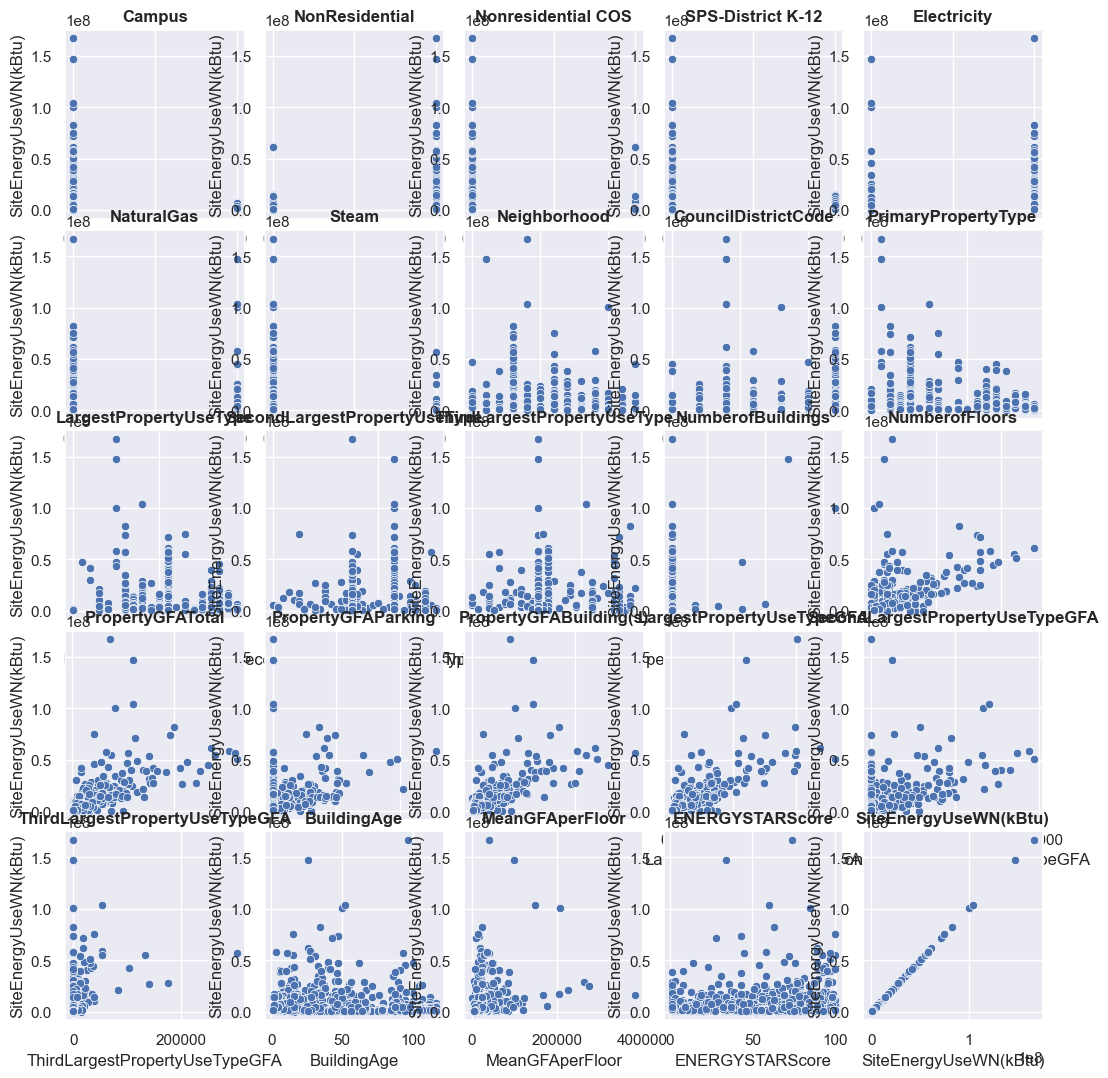

In [1048]:
cols = df_X_ok.columns.to_list()

sns.set()

fig = plt.figure(figsize=(50,150))

for i, c in enumerate(cols,1):
    ax = fig.add_subplot(10,5,i)
    sns.scatterplot(data=df_X_ok, y="SiteEnergyUseWN(kBtu)", x=df_X_ok[c])
    ax.set_title(c)
    ax.title.set_fontweight('bold')

plt.tight_layout(w_pad=1, h_pad=1)
plt.gcf().set_size_inches(10,20)
plt.show()

In [1049]:
df_X_ok = df_X_ok.drop(columns = 'SiteEnergyUseWN(kBtu)')

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Normalisation </h3>
</div>

In [1050]:
df_X_ok.astype('int32').dtypes

Campus                             int32
NonResidential                     int32
Nonresidential COS                 int32
SPS-District K-12                  int32
Electricity                        int32
NaturalGas                         int32
Steam                              int32
Neighborhood                       int32
CouncilDistrictCode                int32
PrimaryPropertyType                int32
LargestPropertyUseType             int32
SecondLargestPropertyUseType       int32
ThirdLargestPropertyUseType        int32
NumberofBuildings                  int32
NumberofFloors                     int32
PropertyGFATotal                   int32
PropertyGFAParking                 int32
PropertyGFABuilding(s)             int32
LargestPropertyUseTypeGFA          int32
SecondLargestPropertyUseTypeGFA    int32
ThirdLargestPropertyUseTypeGFA     int32
BuildingAge                        int32
MeanGFAperFloor                    int32
ENERGYSTARScore                    int32
dtype: object

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.3. Selection des features (basée sur la colinéarité) </h3>
</div>

In [1051]:
def plot_heatmap(corr, title, figsize=(15,10), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=False, annot_kws={"size": 12},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    ax.tick_params(labelsize=12,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=12)
    plt.setp(ax.get_xticklabels(), rotation=40, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=20)

C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\2459594291.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


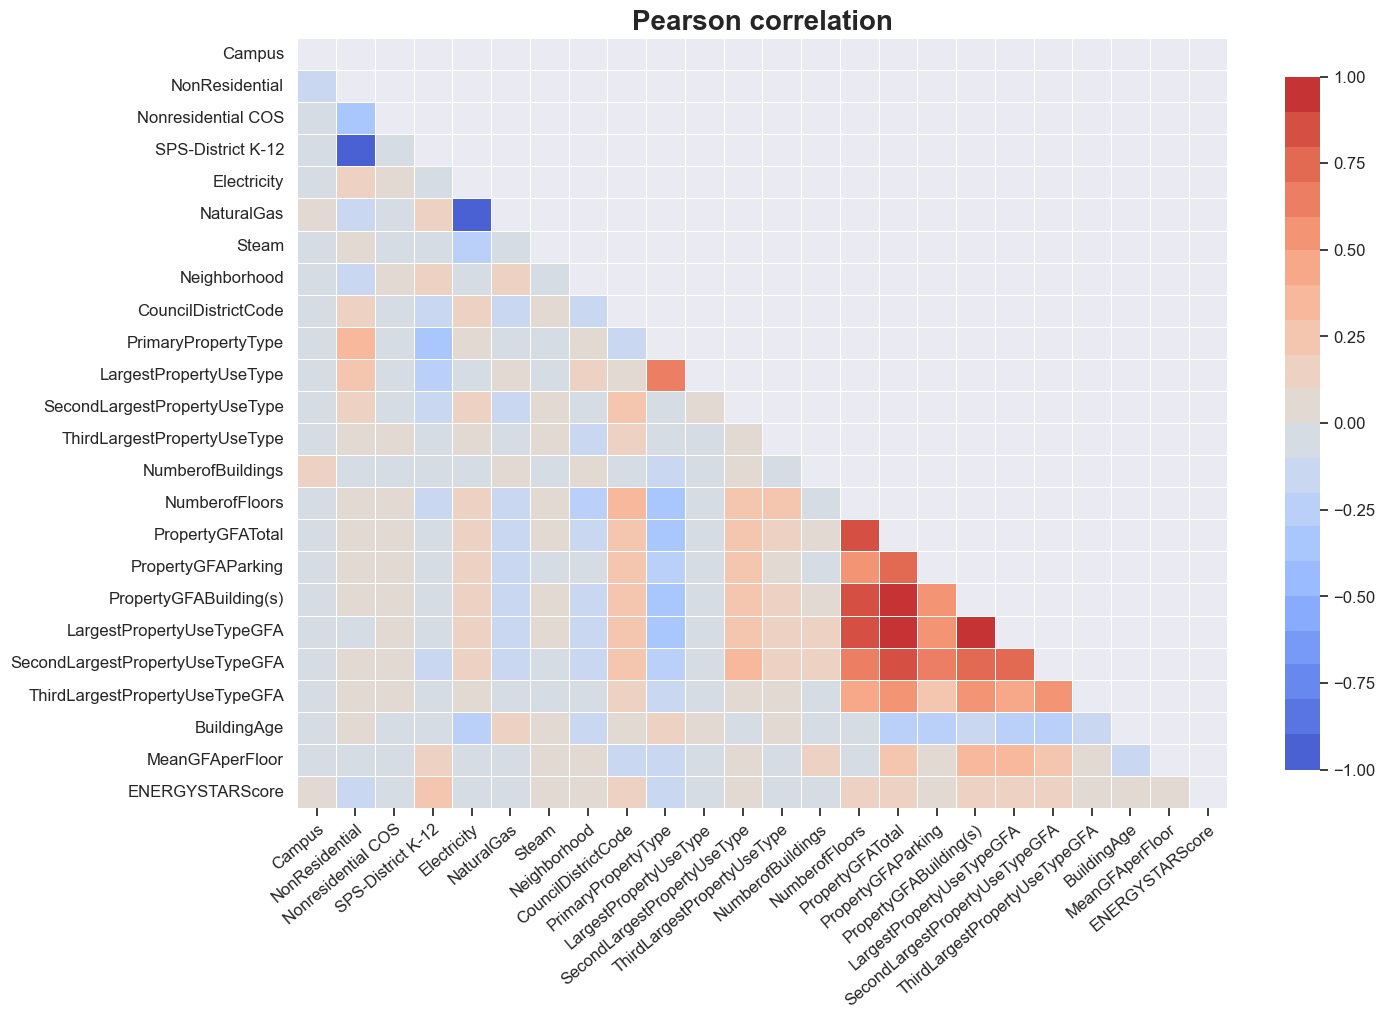

In [1052]:
# a) Feature selection based on colinearity (Pearson correlation)
corr = df_X_ok.corr()
plot_heatmap(corr, 'Pearson correlation', shape='tri')

In [1053]:
for thresh in [0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    li_corr_features = corr[((np.abs(corr)>thresh)&(np.abs(corr)<1)).any(1)].index
    print('---threshold Pearson corr = '+str(thresh)+" ({})".format(str(len(li_corr_features))))
    print(li_corr_features)

---threshold Pearson corr = 0.3 (17)
Index(['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Electricity', 'NaturalGas',
       'CouncilDistrictCode', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'MeanGFAperFloor'],
      dtype='object')
---threshold Pearson corr = 0.4 (13)
Index(['NonResidential', 'SPS-District K-12', 'Electricity', 'NaturalGas', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA'],
      dtype='object')
---threshold Pearson corr = 0.5 (13)
Index(['NonResidential', 'SPS-District K-12', 'Electricity', 'NaturalGas', 'Primar

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Séparation du dataset en train et test </h3>
</div>

<AxesSubplot:>

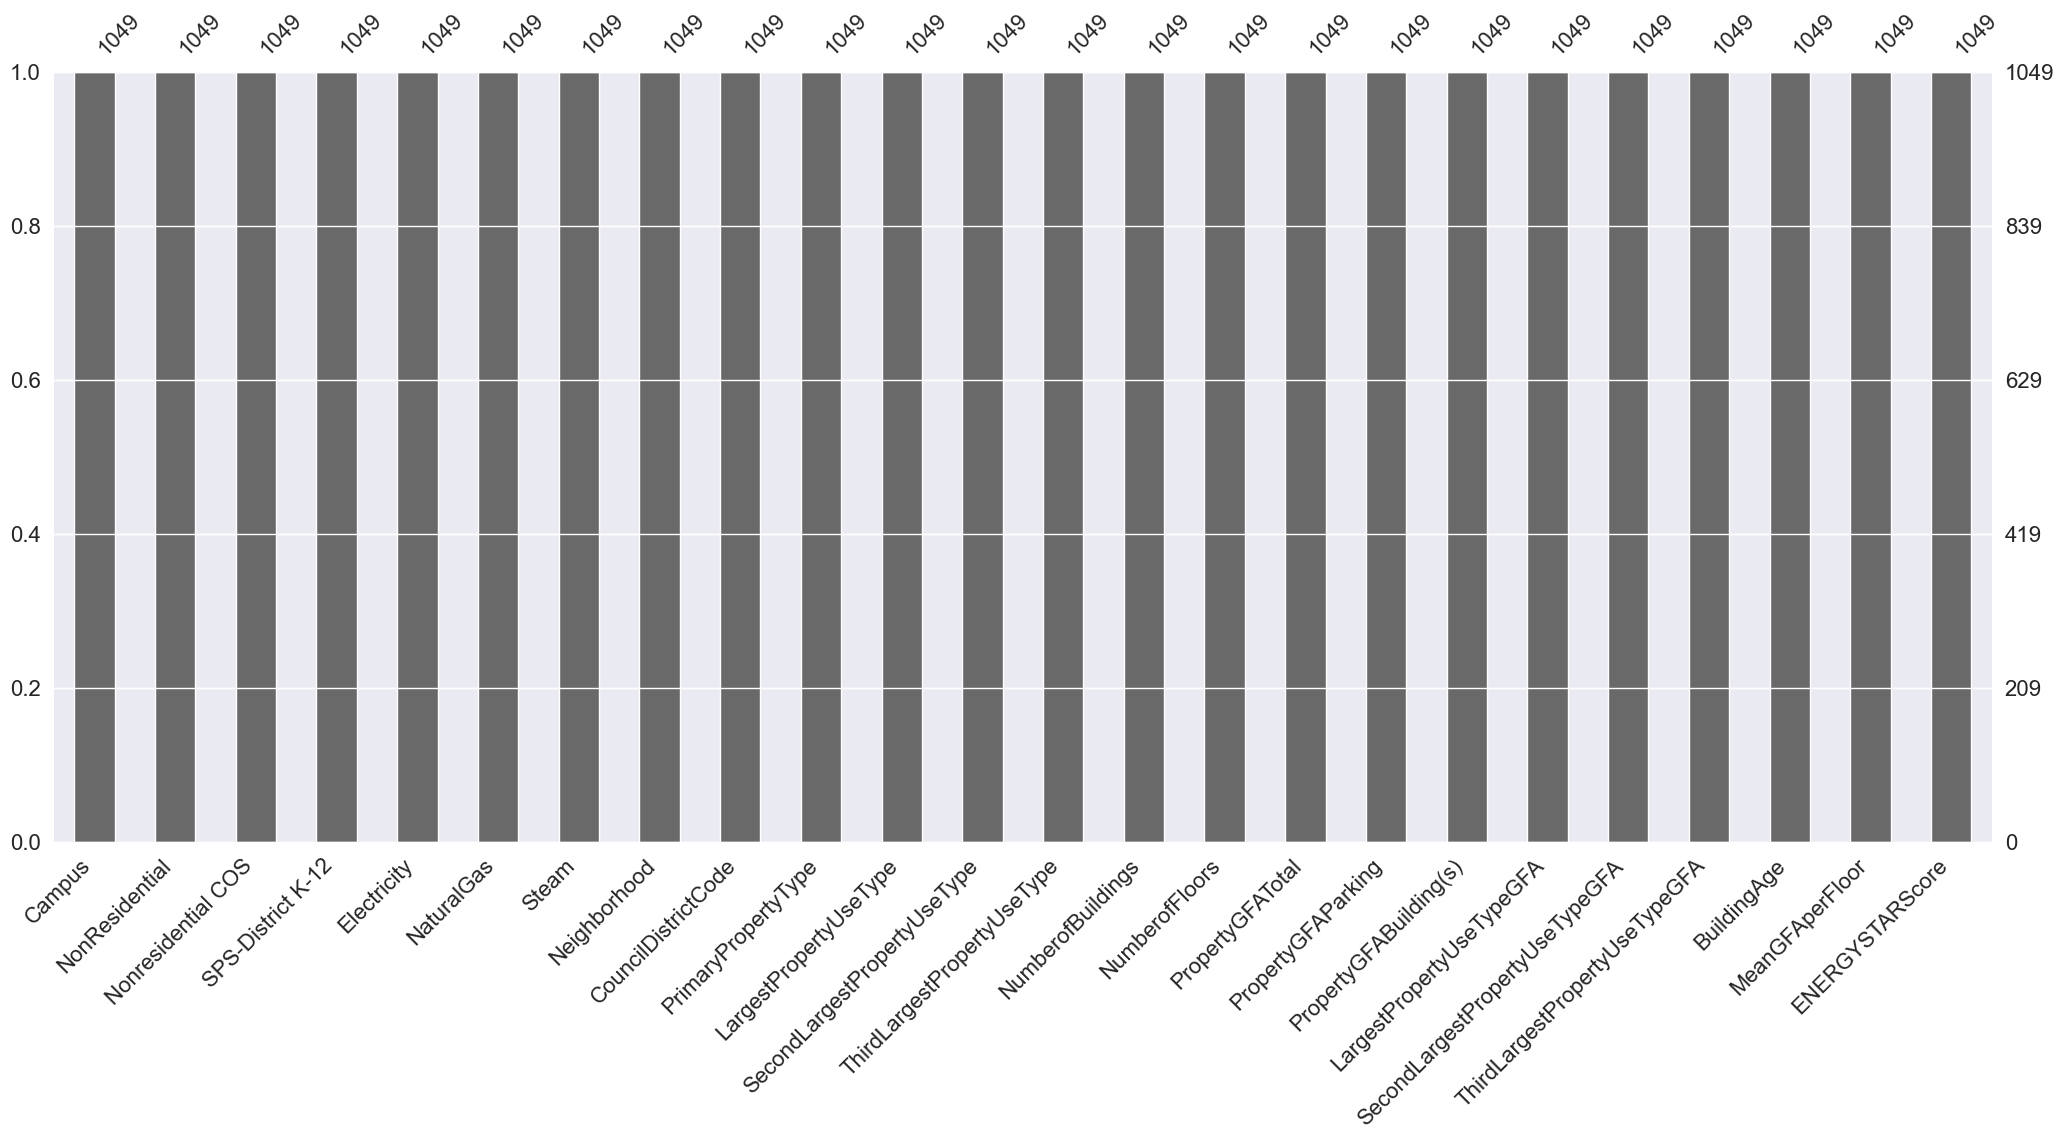

In [1054]:
msno.bar(df_X_ok)

In [1055]:
df_X_ok

,Campus,NonResidential,Nonresidential COS,SPS-District K-12,Electricity,NaturalGas,Steam,Neighborhood,CouncilDistrictCode,PrimaryPropertyType,...,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,BuildingAge,MeanGFAperFloor,ENERGYSTARScore
0,0,1,0,0,1,0,0,3,6,2,...,12,88434,0,88434,88434.00,0.00,0.00,89,6802.62,60.00
1,0,1,0,0,0,1,0,3,6,2,...,11,103566,15064,88502,83880.00,15064.00,4622.00,20,7375.17,61.00
2,0,1,0,0,1,0,0,3,6,2,...,41,956110,196718,759392,756493.00,0.00,0.00,47,18080.76,43.00
3,0,1,0,0,1,0,0,3,6,2,...,10,61320,0,61320,61320.00,0.00,0.00,90,5574.55,56.00
4,0,1,0,0,0,1,0,3,6,2,...,18,175580,62000,113580,123445.00,68009.00,0.00,36,5977.89,75.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,0,1,0,0,0,1,0,5,1,14,...,2,24990,0,24990,24990.00,0.00,0.00,87,8330.00,9.00
3347,0,1,0,0,1,0,0,5,2,3,...,3,45000,0,45000,45728.00,0.00,0.00,1,11250.00,77.00
3366,0,0,1,0,1,0,0,7,6,8,...,1,13661,0,13661,13661.00,0.00,0.00,64,6830.50,75.00
3369,0,0,1,0,1,0,0,11,1,8,...,1,15398,0,15398,15398.00,0.00,0.00,56,7699.00,93.00


In [1056]:
#df_X_ok = df_X_ok.drop(columns = 'ENERGYSTARScore')

In [1057]:
df_y_ok = pd.DataFrame(df['SiteEnergyUseWN(kBtu)']) #ici

In [1058]:
n_random = 20

In [1059]:
X_train, X_temp, y_train, y_temp = train_test_split(df_X_ok, df_y_ok, shuffle=True, train_size=0.8, random_state=n_random)

In [1060]:
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_temp de forme {X_temp.shape} et y_temp de forme {y_temp.shape}")

Nous avons X_train de forme (839, 24) et y_train de forme (839, 1)
Nous avons X_temp de forme (210, 24) et y_temp de forme (210, 1)


In [1061]:
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, shuffle=True, test_size=0.5, random_state=n_random) #ici
#on ne touchera pas a la partie validation du dataset, seulement à la toute fin

In [1062]:
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
print(f"Nous avons X_valid de forme {X_valid.shape} et y_valid de forme {y_valid.shape}")

Nous avons X_test de forme (105, 24) et y_test de forme (105, 1)
Nous avons X_valid de forme (105, 24) et y_valid de forme (105, 1)


In [1063]:
from sklearn import preprocessing
X_std_scale = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True, clip=False).fit(X_train)
X_train_std = pd.DataFrame(X_std_scale.transform(X_train))
X_test_std = pd.DataFrame(X_std_scale.transform(X_test))

In [1064]:
#X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
#X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)

In [1065]:
from sklearn import preprocessing
y_std_scale = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True, clip=False).fit(y_train)
y_train_std = pd.DataFrame(y_std_scale.transform(y_train))
y_test_std = pd.DataFrame(y_std_scale.transform(y_test))

In [1066]:
#y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
#y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Modélisation 1 : KNN regressor </h3>
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1 Entrainement </h3>
</div>

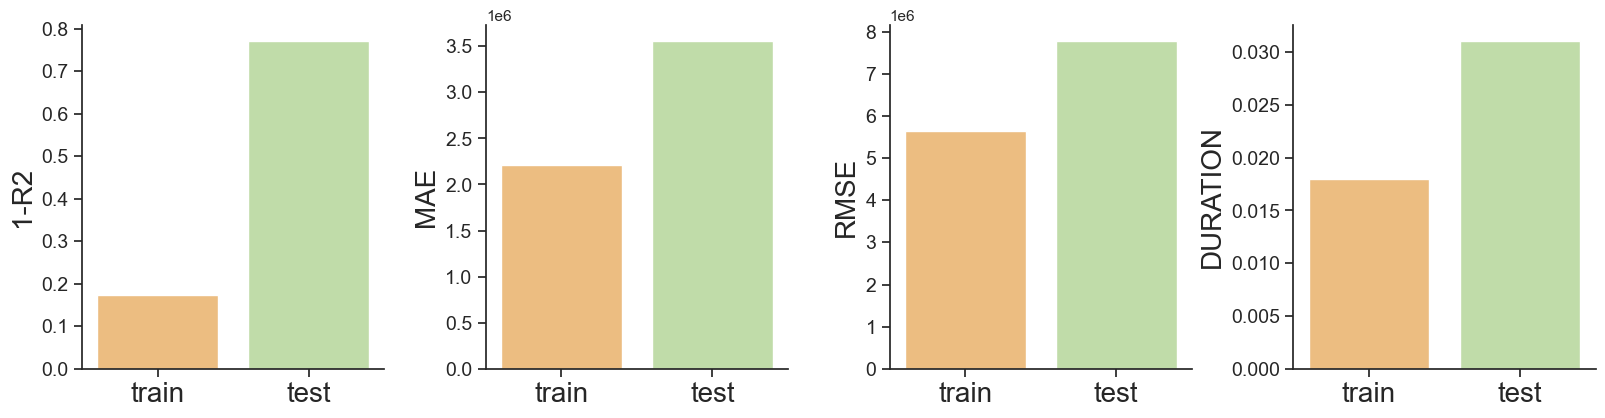

In [1067]:
from sklearn import neighbors
import timeit
from sklearn.metrics import mean_absolute_error

knn_first = neighbors.KNeighborsRegressor(n_neighbors=2)
start_time_model = timeit.default_timer()
knn_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(knn_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(knn_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_knn_first = pd.DataFrame({
    "Modele" : ["knn_first", "knn_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_knn_first, x="Data", y=df_FEATURES_knn_first[c], palette = "Spectral")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2 Prédiction sur le jeu test </h3>
</div>

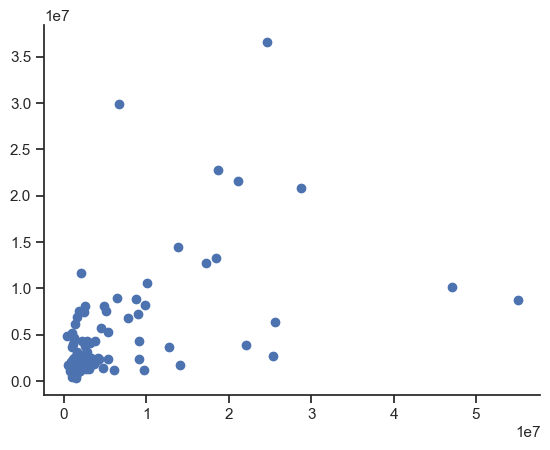

In [1068]:
plt.scatter(y_test_raw, y_pred_test_raw)

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.3 Evaluation </h3>
</div>

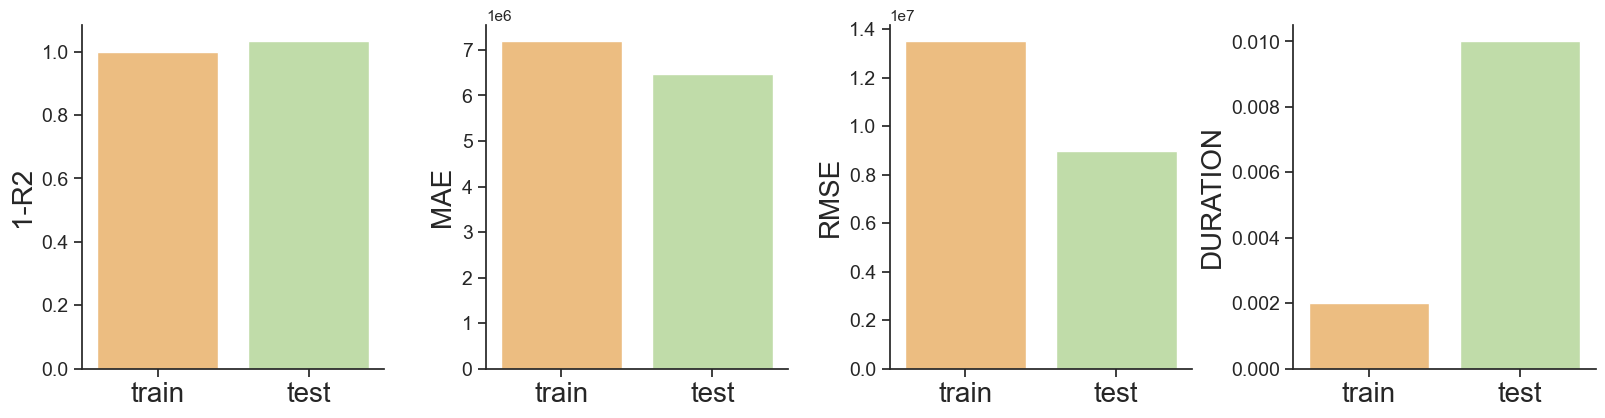

In [1069]:
from sklearn import dummy
knn_dum = dummy.DummyRegressor(strategy='mean')
start_time_model = timeit.default_timer()
knn_dum.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(knn_dum.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(knn_dum.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_knn_dum = pd.DataFrame({
    "Modele" : ["knn_dum", "knn_dum"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_knn_dum, x="Data", y=df_FEATURES_knn_dum[c], palette = "Spectral")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.4 Optimisation Gridsearch</h3>
</div>

In [1070]:
# Select an algorithm
algorithm = KNeighborsRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_neighbors': [2,3,4,5,6,7,8,9,10]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)


0.46864509961739487
KNeighborsRegressor(n_neighbors=4)
{'n_neighbors': 4}


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.5. Entrainement et prédiction optimisée</h3>
</div>

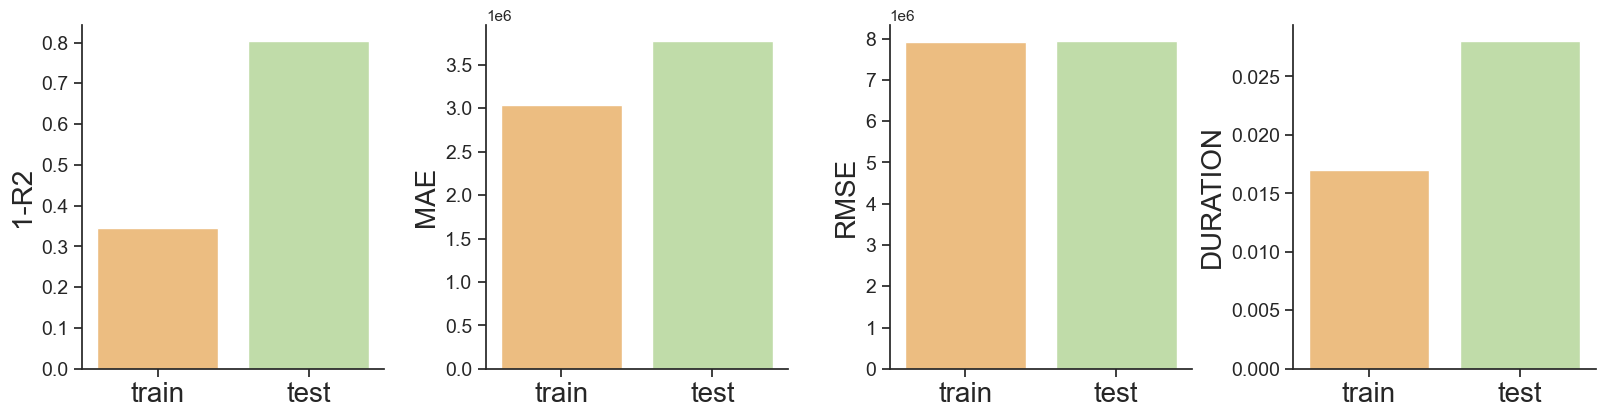

In [1071]:
from sklearn import neighbors
knn_sec = neighbors.KNeighborsRegressor(n_neighbors=4)
start_time_model = timeit.default_timer()
knn_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(knn_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(knn_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_knn_sec = pd.DataFrame({
    "Modele" : ["knn_sec", "knn_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_knn_sec, x="Data", y=df_FEATURES_knn_sec[c], palette = "Spectral")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

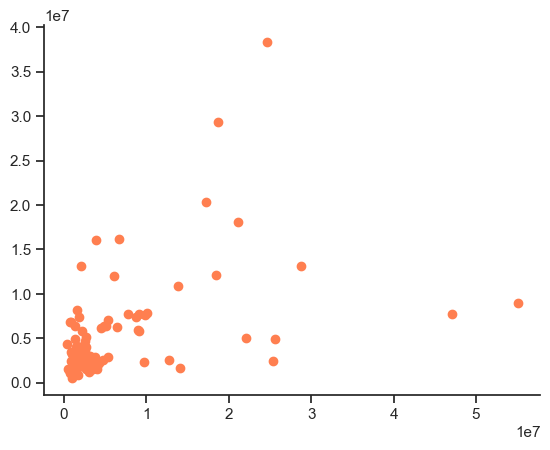

In [1072]:
plt.scatter(y_test_raw, y_pred_test_raw, color='coral')

In [1073]:
y_pred_random = np.random.randint(np.min(y_train_raw), np.max(y_train_raw), y_test_raw.shape)

c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [1074]:
print("R2SCORE :  {:.2f}".format(round(r2_score(y_test_raw, y_pred_random), 3)))
print("MAE :  {:.2f}".format(round(metrics.mean_absolute_error(y_test_raw, y_pred_random), 3)))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test_raw, y_pred_random))))


R2SCORE :  -97.96
MAE :  76289587.04
RMSE : 88056211.67


In [1075]:
#L'algorithme des k plus proches voisins est meilleur qu'une prédiction aléatoire

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5. Modélisation 2 : Regression linéaire </h3>
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1 Entrainement de la régression linéaire baseline </h3>
</div>

In [1076]:
#La première étape est d'effectuer une régression linéaire classique 
#afin de récupérer une erreur baseline, qu'on souhaite améliorer à l'aide des techniques de régularisation.
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train_std, y_train_std)

LinearRegression()

In [1077]:
#On obtient la moyenne des erreurs quadratiques ci-dessous
import numpy as np
baseline_error = np.mean((lr.predict(X_test_std) - y_test_std) ** 2)
print(baseline_error)

0   0.00
dtype: float64


c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [1078]:
#on doit trouver un coefficient de régularisation adapté. Pour rappel, l'objectif est de 
#biaiser un peu la prédiction, afin de diminuer l'erreur standard. 

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2 Régression ridge </h3>
</div>

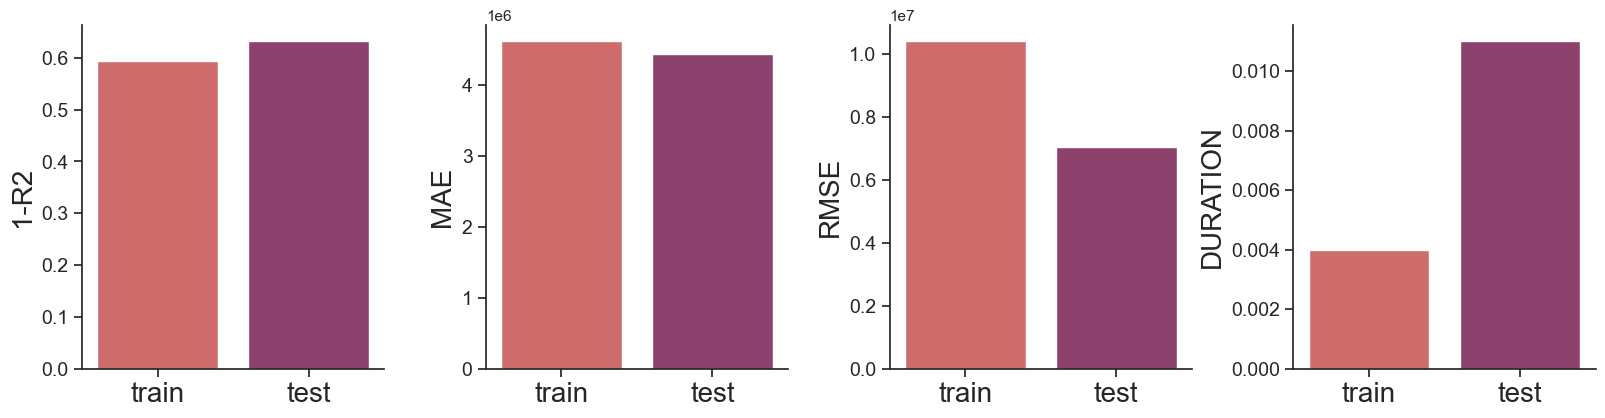

In [1079]:
# Create model
from sklearn.linear_model import Ridge

ridge_first = Ridge(alpha=60, random_state=n_random)
start_time_model = timeit.default_timer()
ridge_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(ridge_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(ridge_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_ridge_first = pd.DataFrame({
    "Modele" : ["ridge_first", "ridge_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_ridge_first, x="Data", y=df_FEATURES_ridge_first[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2.1 Entrainement</h3>
</div>

In [1080]:
#On appelle ce coefficient alpha, on va 
#en tester un certain nombre afin de trouver celui qui est optimal
n_alphas = 70
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
errors = []

for a in alphas:
    ridge_first.set_params(alpha=a)
    ridge_first.fit(X_train_std, y_train_std)
    coefs.append(ridge_first.coef_)
    errors.append(np.mean((ridge_first.predict(X_test_std) - y_test_std) ** 2))

c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Camille B\

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2.2 Prédiction sur le jeu test </h3>
</div>

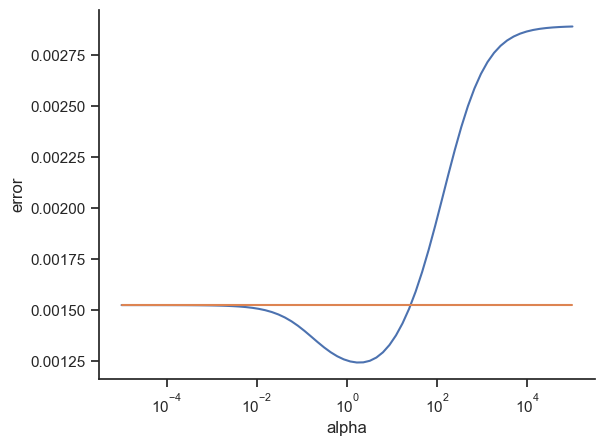

In [1081]:
import matplotlib.pyplot as plt

ax = plt.gca()

ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2.3 Evaluation </h3>
</div>

In [1082]:
#on récupere l'index de l'erreur la plus petite
np.argmin(errors)

36

In [1083]:
#l'erreur la plus petite est XX, l'erreur baseline était de XX
errors[np.argmin(errors)]

0   0.00
dtype: float64

In [1084]:
#Ce parametre de régulation sur notre jeu test et entrainement, a permis de réduit l'erreur quadratique
#On récupere la valeur de l'alpha correspondante = XX
alphas[36]

1.6496480740980206

In [1085]:
#Chemin de régularisation : On peut afficher l'évolution de la valeur des différents poids 
#associés aux paramètres
#ax = plt.gca()

#ax.plot(alphas, coefs)
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('weights')
#plt.title('Ridge coefficients as a function of the regularization')
#plt.axis('tight')
#plt.show()

In [1086]:
#Chemin de régularisation, Les poids des différents paramètres en fonction de alpha 
#Les parametres évoluent en fonction du coef de reg, au alentours de 10^0 parametres ne sont pas completmeent écrasés, et que certains variables correlent car regroupé par le coeff

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2.4 Optimisation CV </h3>
</div>

In [1087]:
# Select an algorithm
algorithm = Ridge()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'alpha': [1,5,10,15,20,25,50,100]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.6430621403057818
Ridge(alpha=1)
{'alpha': 1}


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2.5 Entraînement et prédiction optimisée </h3>
</div>

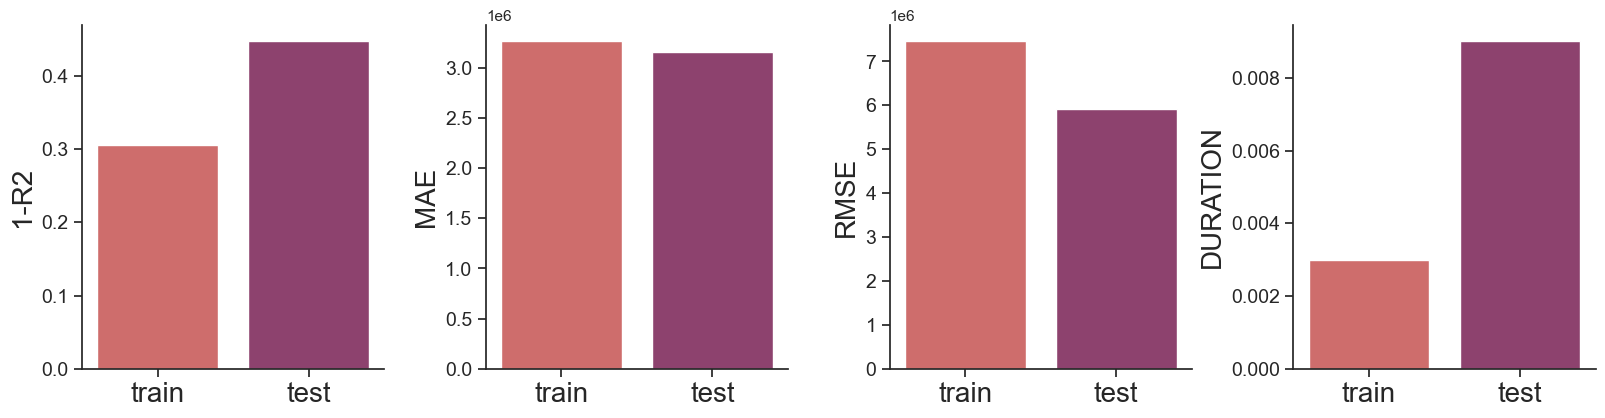

In [1088]:
# Create model
from sklearn.linear_model import Ridge

ridge_sec = Ridge(alpha=1, random_state=n_random)
start_time_model = timeit.default_timer()
ridge_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(ridge_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(ridge_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_ridge_sec = pd.DataFrame({
    "Modele" : ["ridge_sec", "ridge_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_ridge_sec, x="Data", y=df_FEATURES_ridge_sec[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1089]:
# Create a function to plot the magnitude of coefficients on a log scale
#def plotCoef(model, info=""):
#    # Plot the coeffients as bars
#    fig = plt.figure(figsize=(15,4))
#    fig.suptitle(type(model).__name__ + " " + info, fontsize=16)
#    rects = plt.bar(np.arange(len(model.coef_)), model.coef_, color="lightblue")

#    plt.gca().set_xticklabels([])
#    plt.xticks([])
#    plt.yscale('symlog')
#    plt.show()

In [1090]:
# Visualise linear regression coefficients
#plotCoef(lr)

In [1091]:
# Visualise Ridge regression coefficients for different alphas
#coefs_r = []
#for alpha in range(50,70, 1):
#    # Create model
#    model = Ridge(alpha=alpha, random_state=n_random)

    #Fit model
#    model.fit(X_train, y_train)
#    predictions = model.predict(X_train)
#    print("Train:", r2_score(y_train, predictions))

    # Evaluate
#    predictions = model.predict(X_test)
#    print("Test:", r2_score(y_test, predictions))
    
#    plotCoef(model, "alpha="+str(alpha))
#    coefs_r.append(model.coef_)

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3 Régression linéaire Lasso</h3>
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3.1 Entrainement</h3>
</div>

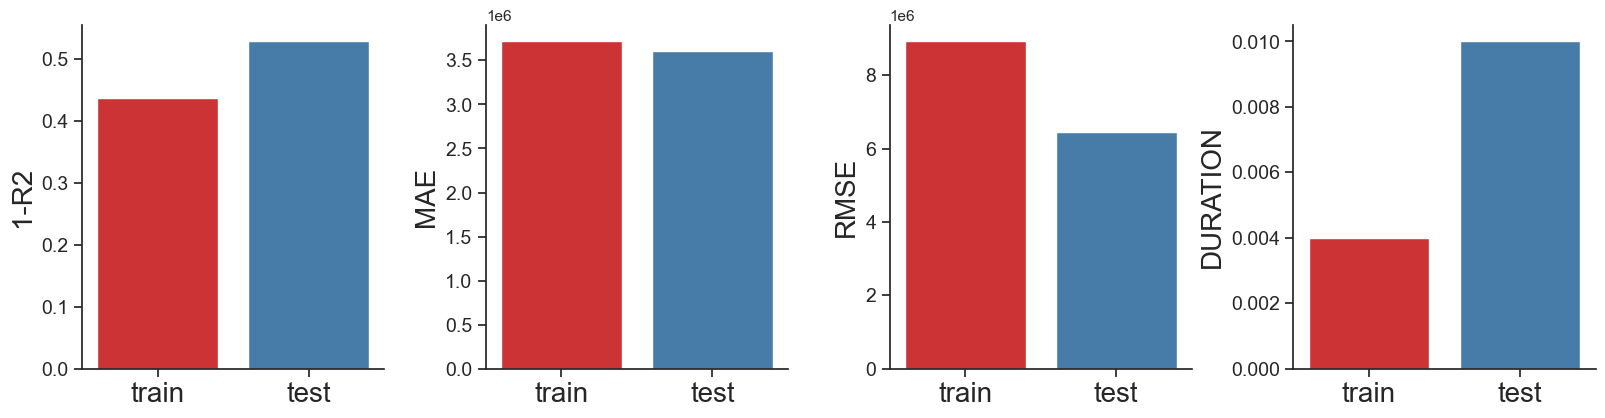

In [1092]:
# Create model
lasso_first = Lasso(alpha=0.002, fit_intercept=False, random_state=n_random)
start_time_model = timeit.default_timer()
lasso_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(lasso_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(lasso_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_lasso_first = pd.DataFrame({
    "Modele" : ["lasso_first", "lasso_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_lasso_first, x="Data", y=df_FEATURES_lasso_first[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3.2 Prédiction sur le jeu test</h3>
</div>

In [1093]:
#On teste aussi un certain nombre d'hyperparamètres pour appliquer le lasso
#n_alphas = 50
#alphas = np.logspace(-5, 5, n_alphas)

#coefs = []
#errors = []
#for a in alphas:
#    lasso_first.set_params(alpha=a)
#    lasso_first.fit(X_train, y_train)
#    coefs.append(lasso_first.coef_)
#    errors.append([baseline_error, np.mean((lasso_first.predict(X_test) - y_test) ** 2)])

In [1094]:
#import matplotlib.pyplot as plt

#ax = plt.gca()

#ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('error')
#plt.axis('tight')
#plt.show()

In [1095]:
#on récupere l'index de l'erreur la plus petite XX
#np.argmin(errors)

In [1096]:
#l'erreur la plus petite est xx, l'erreur baseline était de xx
#errors [np.argmin(errors)] 

In [1097]:
#Ce parametre de régulation sur notre jeu test et entrainement, a permis de réduit l'erreur quadratique

In [1098]:
#On récupere la valeur de l'alpha correspondante = 
#alphas[xx]

In [1099]:
#On peut maintenant afficher les résultats
#ax = plt.gca()

#ax.plot(alphas, coefs)
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('weights')
#plt.axis('tight')
#plt.show()


In [1100]:
#Les poids en fonction de alpha
#Comme on peut le voir, le lasso permet de supprimer des variables en mettant leur poids à zéro. C'est le cas si deux variables sont corrélées. L'une sera sélectionnée par le Lasso, l'autre supprimée. C'est aussi son avantage par rapport à une régression ridge qui ne fera pas de sélection de variables.
#On peut observer maintenant le comportement de l'erreur.
#Erreur en fonction d'alpha : On fait encore mieux qu'avec la régression ridge! En effet comme vu dans les chapitres précédents, le lasso a pour avantage de pouvoir sélectionner un sous-ensemble des variables explicatives afin de permettre une meilleur généralisation.

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3.4 Optimisation Lasso CV </h3>
</div>

In [1101]:
# Select an algorithm
algorithm = Lasso()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'alpha': [0.01,0.015,0.020,0.025]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-0.00249936067979184
Lasso(alpha=0.01)
{'alpha': 0.01}


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3.5 Entrainemement et prédiction optimisée</h3>
</div>

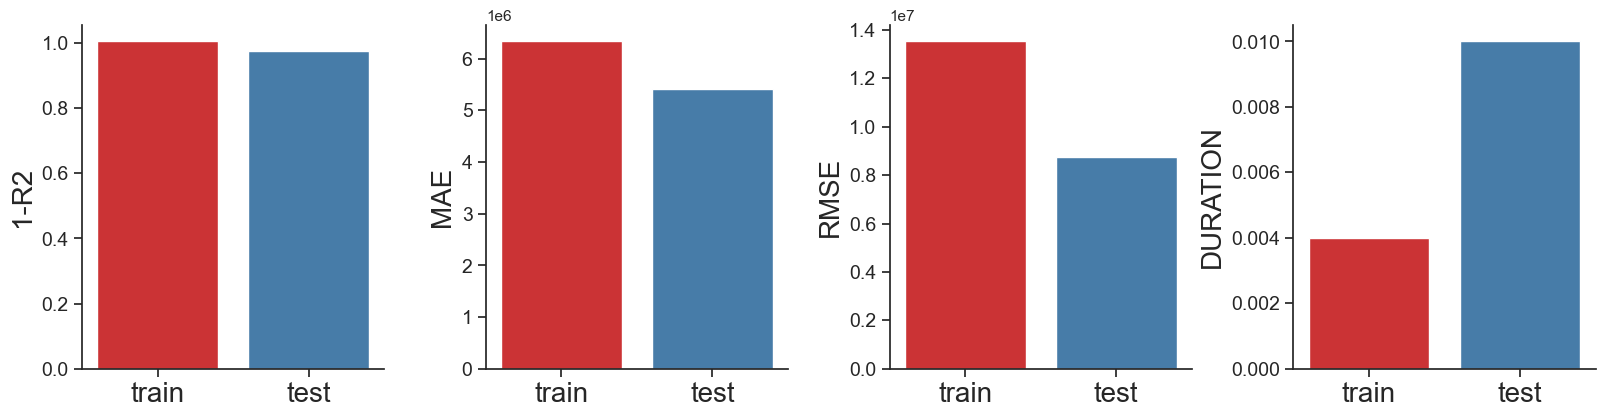

In [1102]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

lasso_sec = Lasso(alpha=0.01, fit_intercept=False, random_state=n_random)
start_time_model = timeit.default_timer()
lasso_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(lasso_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(lasso_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_lasso_sec = pd.DataFrame({
    "Modele" : ["lasso_sec", "lasso_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_lasso_sec, x="Data", y=df_FEATURES_lasso_sec[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1103]:
# Visualise Lasso regression coefficients for different alphas
#coefs_l = []
#for alpha in range(0, 2):
#    # Create model
#    model = Lasso(alpha=alpha, random_state=n_random)

#Fit model
#    model.fit(X_train, y_train)
#    predictions = model.predict(X_train)
#    print("Train:", r2_score(y_train, predictions))

# Evaluate
#    predictions = model.predict(X_test)
#    print("Test:", r2_score(y_test, predictions))
    
#    plotCoef(model, "alpha="+str(alpha))
#    coefs_l.append(model.coef_)

In [1104]:
# Prove that Ridge is reducing overall magnitude of coeficients with increasing alpha
# Should return an array of diminishing values
#np.sum(abs(np.array(coefs_r)), axis=1)

In [1105]:
# Prove that Lasso is reducing overall magnitude of coeficients with increasing alpha
# Should return an array of diminishing values
#np.sum(abs(np.array(coefs_l)), axis=1)

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4 ElasticNet</h3>
</div>

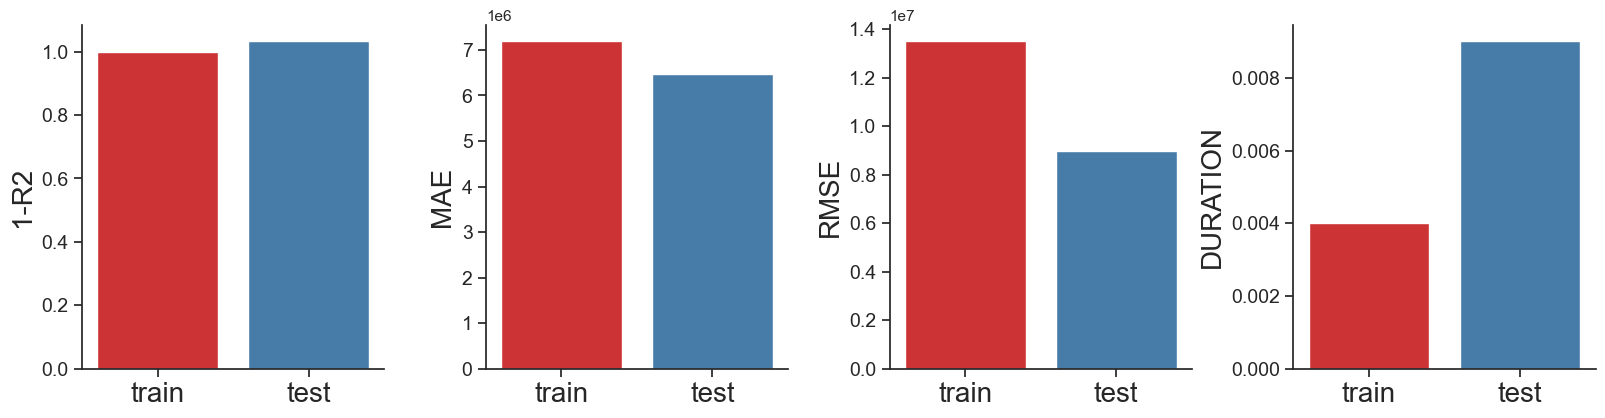

In [1106]:
from sklearn.linear_model import ElasticNet
from time import time

elnet_first = ElasticNet(alpha=1, l1_ratio=0.5, random_state=n_random)

start_time_model = timeit.default_timer()
elnet_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(elnet_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(elnet_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_elnet_first = pd.DataFrame({
    "Modele" : ["elnet_first", "elnet_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_elnet_first, x="Data", y=df_FEATURES_elnet_first[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1107]:
from sklearn.linear_model import ElasticNetCV

# Select an algorithm
algorithm = ElasticNet()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'alpha': [0.01,0.025,0.05]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.2691888141118629
ElasticNet(alpha=0.01)
{'alpha': 0.01}


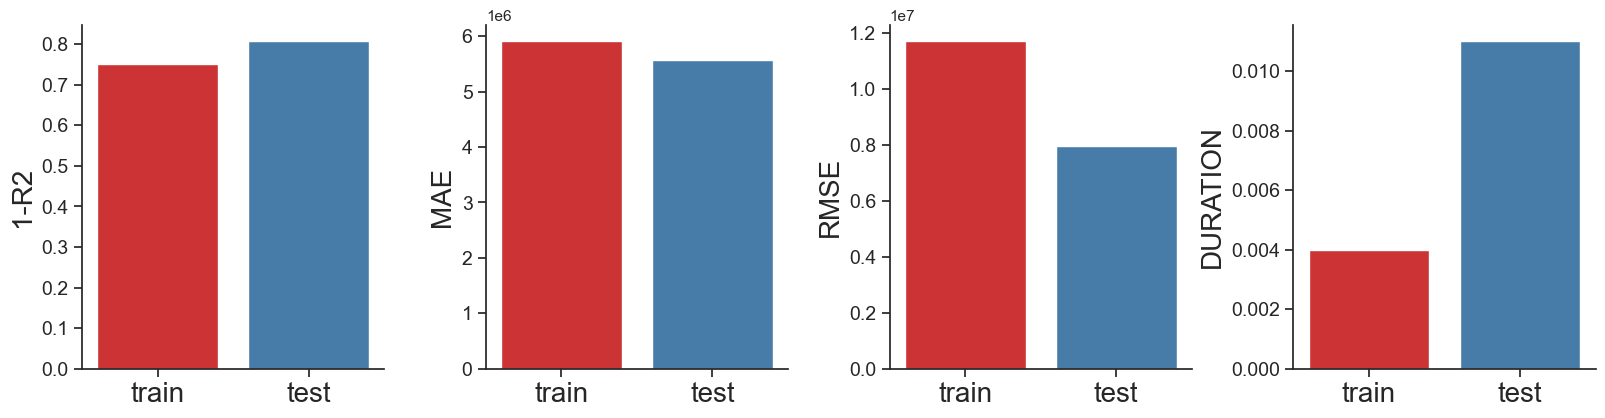

In [1108]:
from sklearn.linear_model import ElasticNet
from time import time

elnet_sec = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=n_random)
start_time_model = timeit.default_timer()
elnet_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(elnet_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(elnet_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_elnet_sec = pd.DataFrame({
    "Modele" : ["elnet_sec", "elnet_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_elnet_sec, x="Data", y=df_FEATURES_elnet_sec[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.5 SVR</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


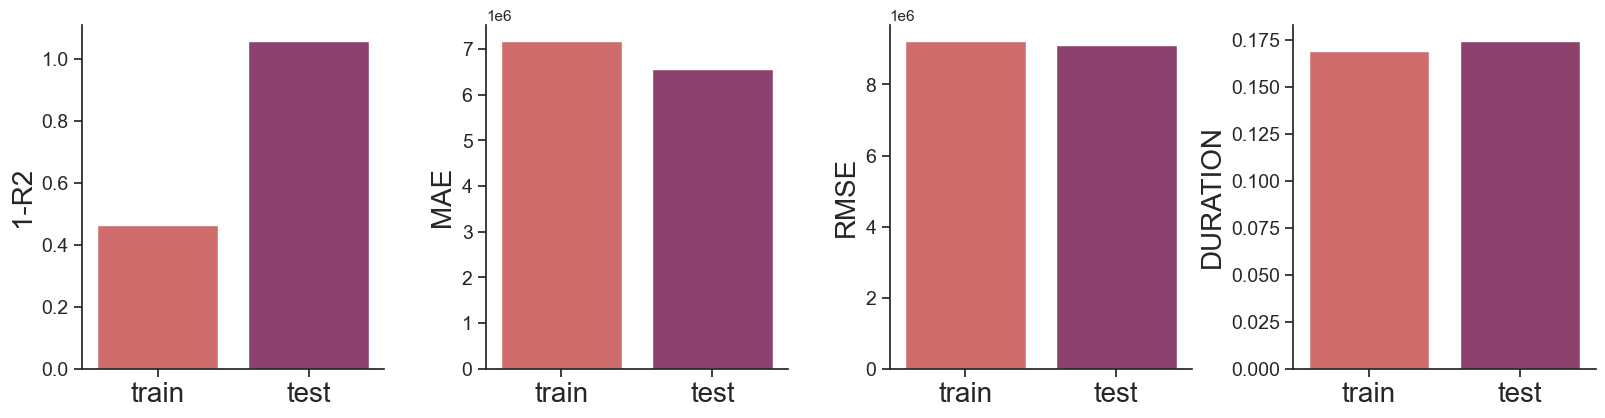

In [1109]:
from sklearn.svm import LinearSVR
svr_first = SVR(kernel="linear", C=200, gamma="auto")
start_time_model = timeit.default_timer()
svr_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(svr_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(svr_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_svr_first = pd.DataFrame({
    "Modele" : ["svr_first", "svr_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_svr_first, x="Data", y=df_FEATURES_svr_first[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1110]:
# Select an algorithm
algorithm = SVR()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'C': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.2380224237655726
SVR(C=100)
{'C': 100}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


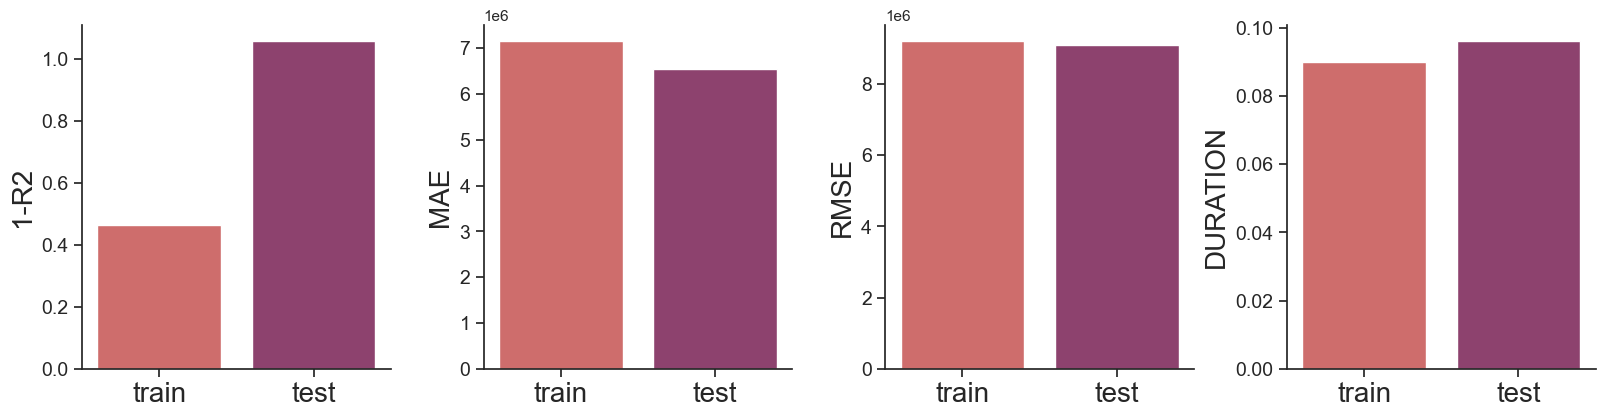

In [1111]:
from sklearn.svm import LinearSVR
svr_sec = SVR(kernel="linear", C=100, gamma="auto")
start_time_model = timeit.default_timer()
svr_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(svr_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(svr_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_svr_sec = pd.DataFrame({
    "Modele" : ["svr_sec", "svr_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_svr_sec, x="Data", y=df_FEATURES_svr_sec[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1112]:
#Modèles linéaires pas terribles, essayons avec des modèles ensemblistes

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6. BAGGING</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


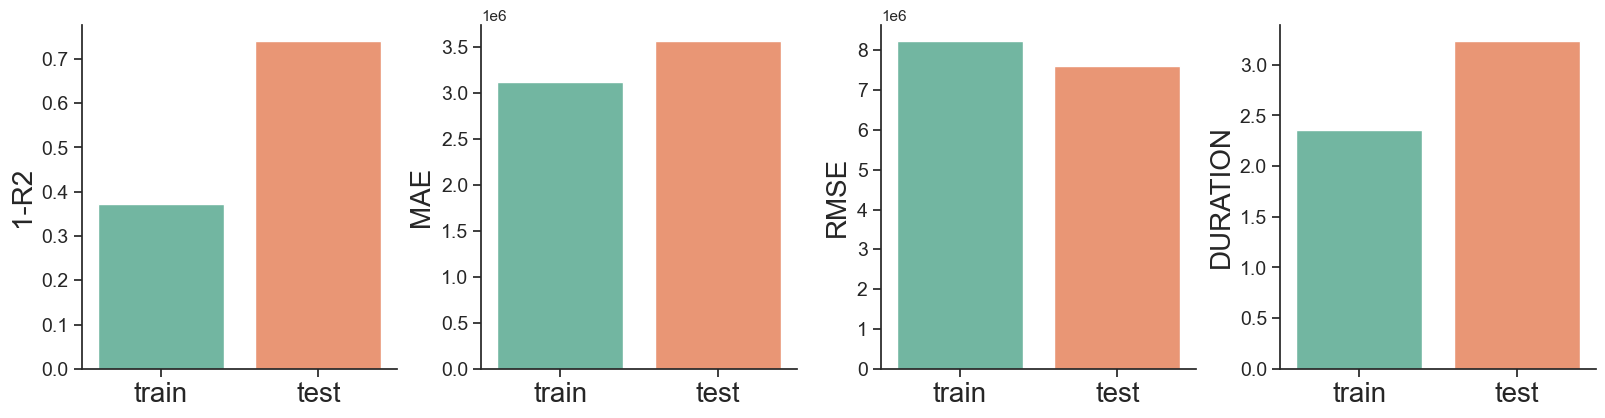

In [1113]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

bagregr_first = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=200, random_state=n_random)
start_time_model = timeit.default_timer()
bagregr_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(bagregr_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(bagregr_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_bagregr_first = pd.DataFrame({
    "Modele" : ["bagregr_first", "bagregr_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_bagregr_first, x="Data", y=df_FEATURES_bagregr_first[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1114]:
# Select an algorithm
algorithm = BaggingRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

0.7384816915392434
BaggingRegressor(n_estimators=100)
{'n_estimators': 100}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


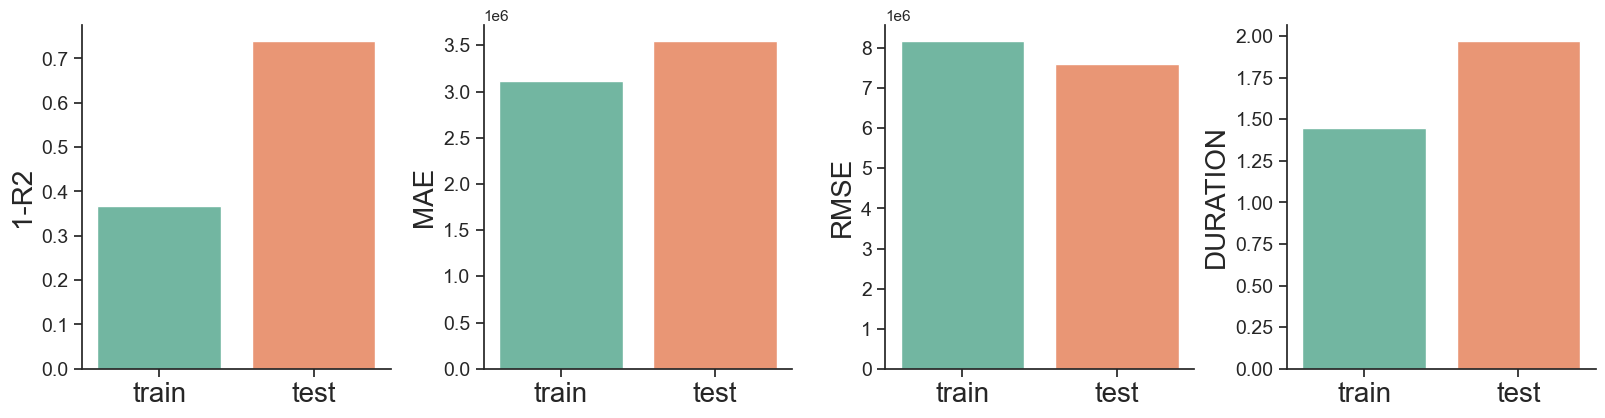

In [1115]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

bagregr_sec = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=100, random_state=n_random)
start_time_model = timeit.default_timer()
bagregr_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(bagregr_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(bagregr_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_bagregr_sec = pd.DataFrame({
    "Modele" : ["bagregr_sec", "bagregr_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_bagregr_sec, x="Data", y=df_FEATURES_bagregr_sec[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\3704014109.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforegr_first.fit(X_train_std, y_train_std)


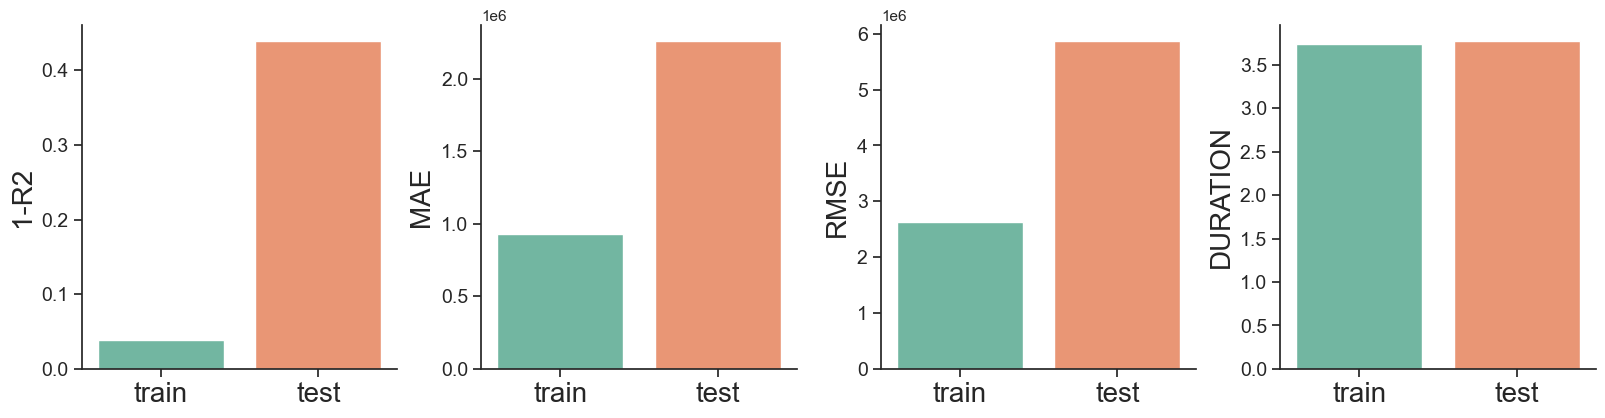

In [1116]:
rforegr_first = RandomForestRegressor(n_estimators = 500, random_state=n_random)
start_time_model = timeit.default_timer()
rforegr_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(rforegr_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(rforegr_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_rforegr_first = pd.DataFrame({
    "Modele" : ["rforegr_first", "rforegr_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_rforegr_first, x="Data", y=df_FEATURES_rforegr_first[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1117]:
# Select an algorithm
algorithm = RandomForestRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A co

0.7312786368525659
RandomForestRegressor(n_estimators=400)
{'n_estimators': 400}


C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\2533033012.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforegr_sec.fit(X_train_std, y_train_std)


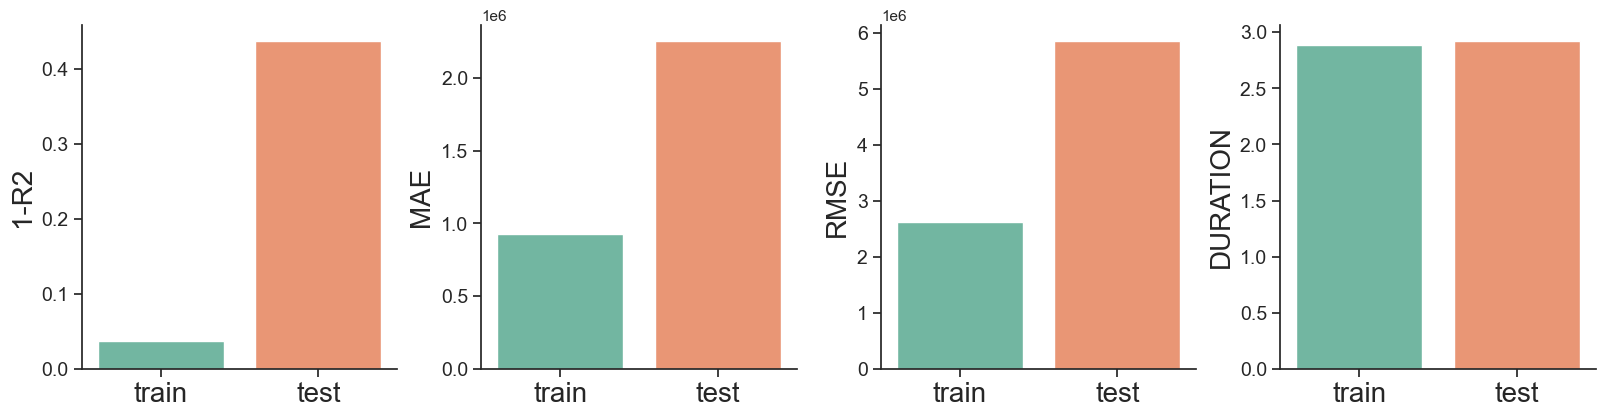

In [1118]:
rforegr_sec = RandomForestRegressor(n_estimators = 400, random_state=n_random)
start_time_model = timeit.default_timer()
rforegr_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(rforegr_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(rforegr_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_rforegr_sec = pd.DataFrame({
    "Modele" : ["rforegr_sec", "rforegr_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_rforegr_sec, x="Data", y=df_FEATURES_rforegr_sec[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7. BOOSTING</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


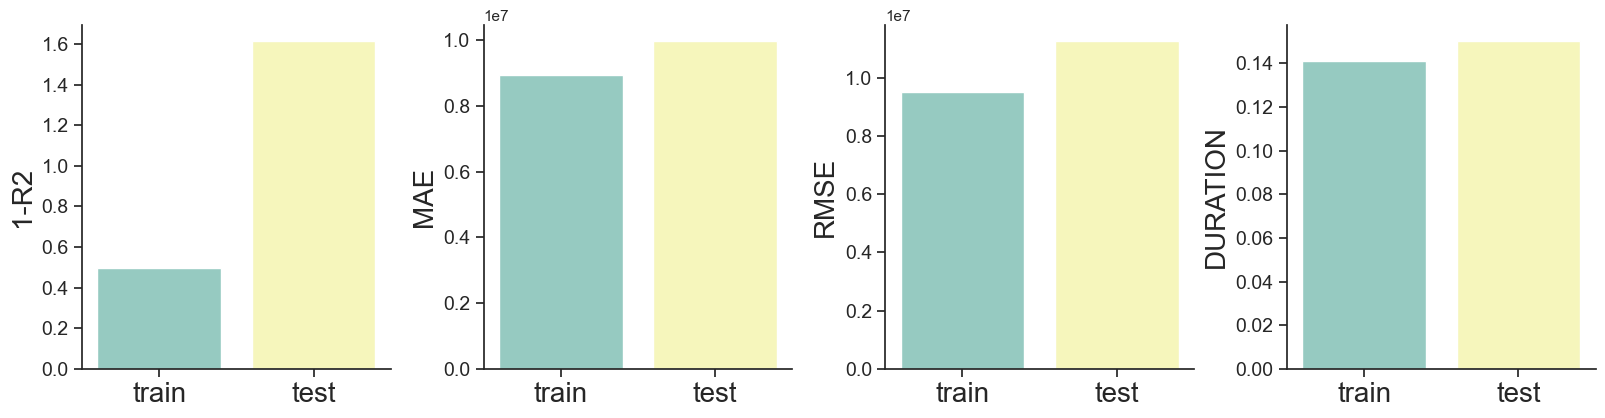

In [1119]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

adaboostregr_first = AdaBoostRegressor(n_estimators = 100, random_state=n_random)
start_time_model = timeit.default_timer()
adaboostregr_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(adaboostregr_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(adaboostregr_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_adaboostregr_first = pd.DataFrame({
    "Modele" : ["adaboostregr_first", "adaboostregr_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_adaboostregr_first, x="Data", y=df_FEATURES_adaboostregr_first[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()


In [1120]:
# Select an algorithm
algorithm = AdaBoostRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

0.37608442593200325
AdaBoostRegressor(n_estimators=100)
{'n_estimators': 100}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


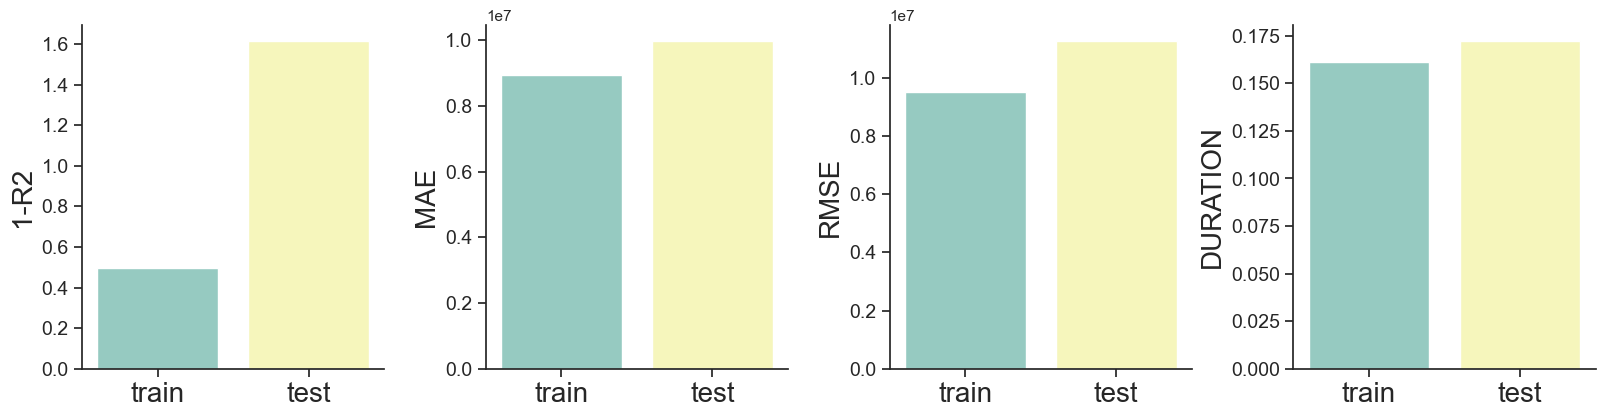

In [1121]:
adaboostregr_sec = AdaBoostRegressor(n_estimators = 100, random_state=n_random)
start_time_model = timeit.default_timer()
adaboostregr_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(adaboostregr_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(adaboostregr_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_adaboostregr_sec = pd.DataFrame({
    "Modele" : ["adaboostregr_sec", "adaboostregr_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_adaboostregr_sec, x="Data", y=df_FEATURES_adaboostregr_sec[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


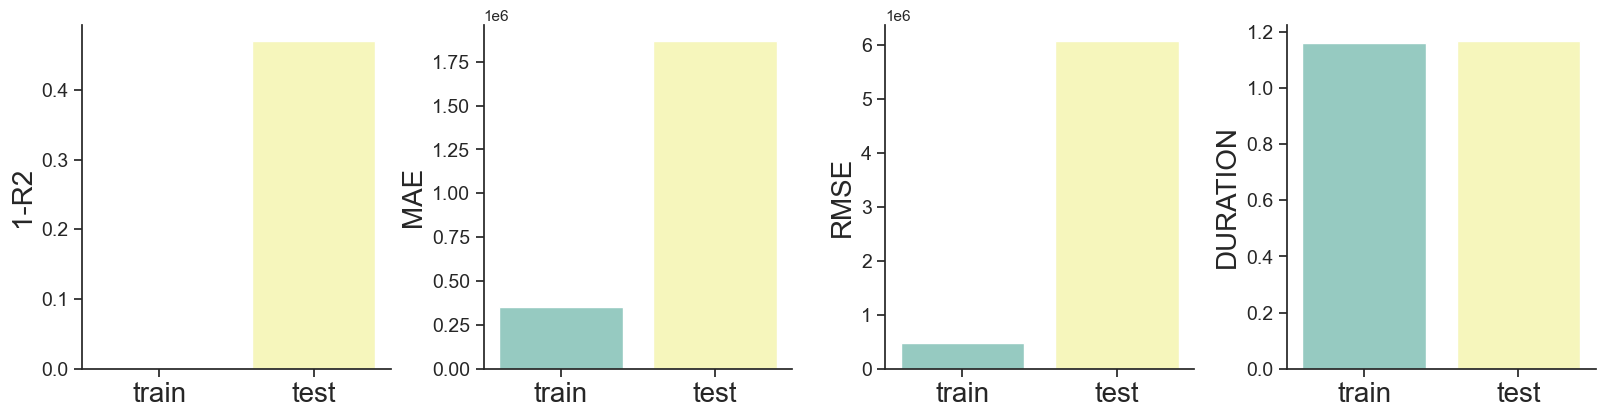

In [1122]:
gboostregr_first = GradientBoostingRegressor(n_estimators = 500, random_state=n_random)
start_time_model = timeit.default_timer()
gboostregr_first.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(gboostregr_first.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(gboostregr_first.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_gboostregr_first = pd.DataFrame({
    "Modele" : ["gboostregr_first", "gboostregr_first"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_gboostregr_first, x="Data", y=df_FEATURES_gboostregr_first[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1123]:
# Select an algorithm
algorithm = GradientBoostingRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_std, y_train_std)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.8008891841879269
GradientBoostingRegressor(n_estimators=400)
{'n_estimators': 400}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


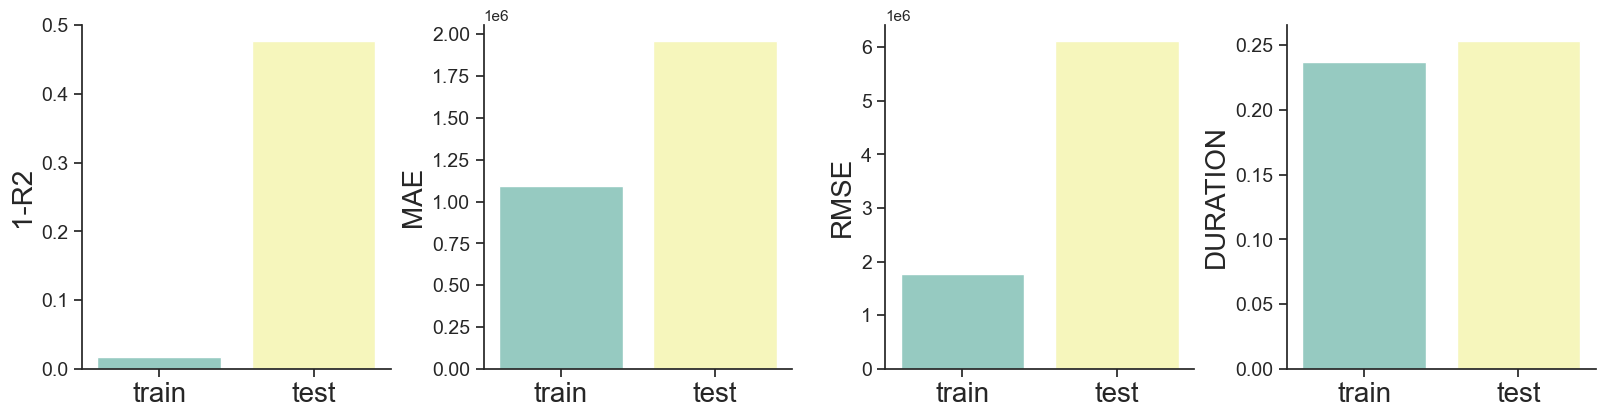

In [1124]:
gboostregr_sec = GradientBoostingRegressor(n_estimators = 100, random_state=n_random)
start_time_model = timeit.default_timer()
gboostregr_sec.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(gboostregr_sec.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_std = pd.DataFrame(gboostregr_sec.predict(X_test_std), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_pred_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_gboostregr_sec = pd.DataFrame({
    "Modele" : ["gboostregr_sec", "gboostregr_sec"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_gboostregr_sec, x="Data", y=df_FEATURES_gboostregr_sec[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[ 67 134 201 268 335 402 469 536 603 671]


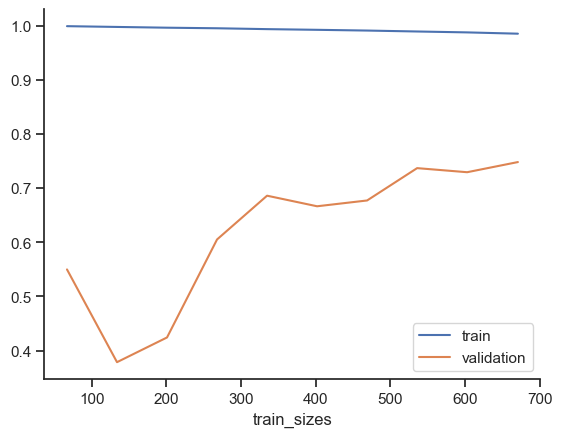

In [1125]:
from sklearn.model_selection import learning_curve
model = GradientBoostingRegressor()
N, train_score, val_score = learning_curve(model, X_train_std, y_train_std,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [1126]:
df_FEATURES_gboostregr_sec

,Modele,Data,1-R2,MAE,RMSE,DURATION
0,gboostregr_sec,train,0.02,1095645.88,1760695.83,0.24
1,gboostregr_sec,test,0.48,1957782.01,6110528.30,0.25


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">GRAPHIQUES METRICS </h3>
</div>

In [1127]:
df_final_energy = pd.concat([df_FEATURES_knn_first, df_FEATURES_knn_sec, 
                             df_FEATURES_ridge_first, df_FEATURES_ridge_sec,
                             df_FEATURES_lasso_first, df_FEATURES_lasso_sec, 
                             df_FEATURES_elnet_first, df_FEATURES_elnet_sec,
                             df_FEATURES_svr_first, df_FEATURES_svr_sec, 
                             df_FEATURES_bagregr_first, df_FEATURES_bagregr_sec,
                             df_FEATURES_rforegr_first, df_FEATURES_rforegr_sec, 
                             df_FEATURES_adaboostregr_first, df_FEATURES_adaboostregr_sec,
                             df_FEATURES_gboostregr_first, df_FEATURES_gboostregr_sec], axis=0)
df_final_energy

,Modele,Data,1-R2,MAE,RMSE,DURATION
0,knn_first,train,0.17,2214993.75,5637677.78,0.02
1,knn_first,test,0.77,3552633.66,7768060.91,0.03
0,knn_sec,train,0.34,3033760.48,7917202.04,0.02
1,knn_sec,test,0.80,3769719.98,7931221.63,0.03
0,ridge_first,train,0.59,4613211.84,10399958.25,0.00
1,ridge_first,test,0.63,4431235.28,7033914.51,0.01
0,ridge_sec,train,0.31,3260259.54,7455576.75,0.00
1,ridge_sec,test,0.45,3157833.22,5918216.00,0.01
0,lasso_first,train,0.44,3714383.50,8917742.22,0.00
1,lasso_first,test,0.53,3611204.73,6438071.14,0.01


In [1128]:
#fig, ax1 = plt.subplots(figsize=(15, 6))
#plot = sns.barplot(x="Data", y="Value", hue="Metric", data=df_final_energy, ax=ax1)
#for p in plot.patches:
#    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="center", xytext=(0, 8), textcoords="offset points")
#plt.title("Comparison of Metrics by data (Energy)", size=20)
#plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0, title="Metrics")
#plt.tight_layout()
#plt.xticks(rotation = 'vertical')
#plt.ylabel("Metric", size=14)

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.3. Séparation du dataset LOG en train et test </h3>
</div>

In [1129]:
df_X_ok

,Campus,NonResidential,Nonresidential COS,SPS-District K-12,Electricity,NaturalGas,Steam,Neighborhood,CouncilDistrictCode,PrimaryPropertyType,...,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,BuildingAge,MeanGFAperFloor,ENERGYSTARScore
0,0,1,0,0,1,0,0,3,6,2,...,12,88434,0,88434,88434.00,0.00,0.00,89,6802.62,60.00
1,0,1,0,0,0,1,0,3,6,2,...,11,103566,15064,88502,83880.00,15064.00,4622.00,20,7375.17,61.00
2,0,1,0,0,1,0,0,3,6,2,...,41,956110,196718,759392,756493.00,0.00,0.00,47,18080.76,43.00
3,0,1,0,0,1,0,0,3,6,2,...,10,61320,0,61320,61320.00,0.00,0.00,90,5574.55,56.00
4,0,1,0,0,0,1,0,3,6,2,...,18,175580,62000,113580,123445.00,68009.00,0.00,36,5977.89,75.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,0,1,0,0,0,1,0,5,1,14,...,2,24990,0,24990,24990.00,0.00,0.00,87,8330.00,9.00
3347,0,1,0,0,1,0,0,5,2,3,...,3,45000,0,45000,45728.00,0.00,0.00,1,11250.00,77.00
3366,0,0,1,0,1,0,0,7,6,8,...,1,13661,0,13661,13661.00,0.00,0.00,64,6830.50,75.00
3369,0,0,1,0,1,0,0,11,1,8,...,1,15398,0,15398,15398.00,0.00,0.00,56,7699.00,93.00


In [1130]:
df_y_ok

,SiteEnergyUseWN(kBtu)
0,7456910.00
1,8664479.00
2,73937112.00
3,6946800.50
4,14656503.00
...,...
3339,4731813.50
3347,1397742.38
3366,558525.12
3369,414172.41


In [1131]:
n_random = 20

In [1132]:
X_train, X_temp, y_train, y_temp = train_test_split(df_X_ok, df_y_ok, shuffle=True, train_size=0.8, random_state=n_random)

In [1133]:
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_temp de forme {X_temp.shape} et y_temp de forme {y_temp.shape}")

Nous avons X_train de forme (839, 24) et y_train de forme (839, 1)
Nous avons X_temp de forme (210, 24) et y_temp de forme (210, 1)


In [1134]:
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, shuffle=True, test_size=0.5, random_state=n_random) #ici
#on ne touchera pas a la partie validation du dataset, seulement à la toute fin

In [1135]:
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
print(f"Nous avons X_valid de forme {X_valid.shape} et y_valid de forme {y_valid.shape}")

Nous avons X_test de forme (105, 24) et y_test de forme (105, 1)
Nous avons X_valid de forme (105, 24) et y_valid de forme (105, 1)


In [1136]:
X_train_l = pd.DataFrame(X_train+1)
X_train_log = pd.DataFrame(np.log(X_train_l))
#X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)

X_test_l = pd.DataFrame(X_test+1)
X_test_log = pd.DataFrame(np.log(X_test_l))
#X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)

In [1137]:
y_train_l = pd.DataFrame(y_train+1)
y_train_log = pd.DataFrame(np.log(y_train_l))
#y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)

y_test_l = pd.DataFrame(y_test+1)
y_test_log = pd.DataFrame(np.log(y_test_l))
#y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.4. Modélisation 1 : KNN regressor </h3>
</div>

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.4.1 Entrainement </h3>
</div>

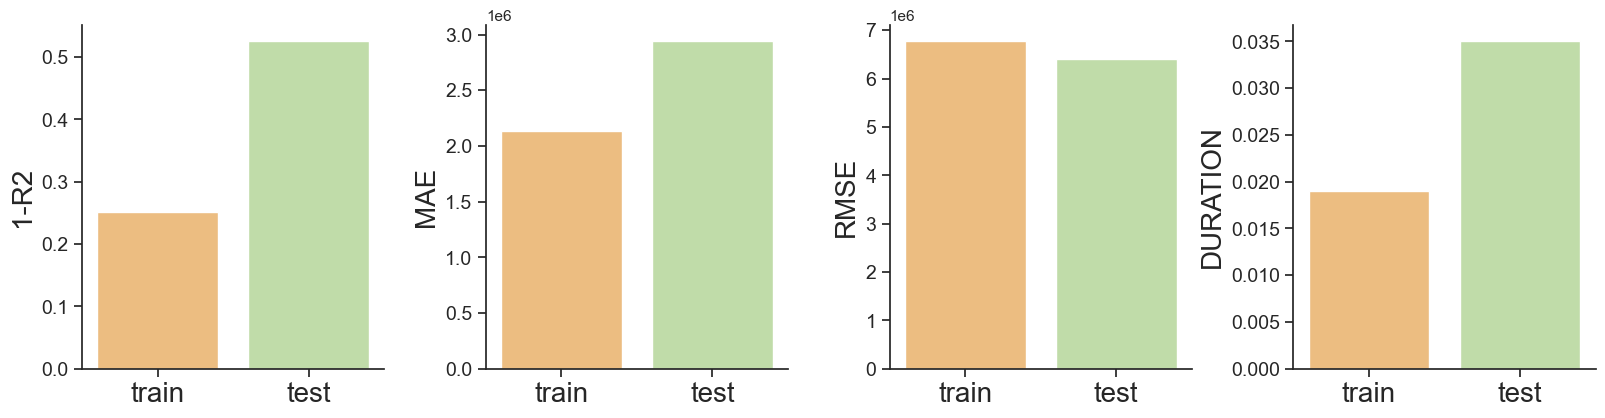

In [1138]:
from sklearn import neighbors
knn_first_log = neighbors.KNeighborsRegressor(n_neighbors=2)
start_time_model = timeit.default_timer()
knn_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(knn_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(knn_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_knn_first_log = pd.DataFrame({
    "Modele" : ["knn_first_log", "knn_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_knn_first_log, x="Data", y=df_FEATURES_knn_first_log[c], palette = "Spectral")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.4.2 Prédiction sur le jeu test </h3>
</div>

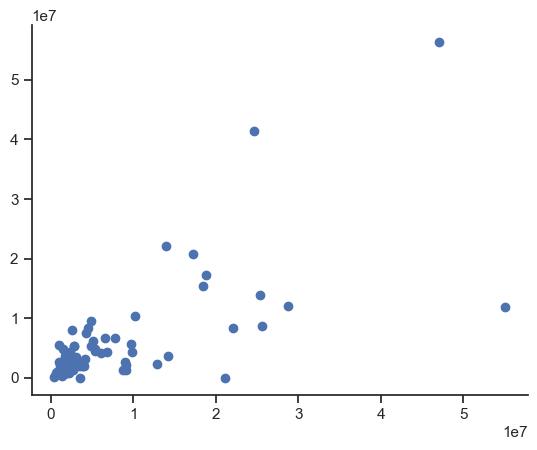

In [1139]:
plt.scatter(y_test_raw, y_pred_test_raw)

In [1140]:
#sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
#for (yt, yp) in zip(list(y_test_raw), list(y_pred_test_raw)):
#    if (yt, yp) in sizes:
#        sizes[(yt, yp)] += 1
#    else:
#        sizes[(yt, yp)] = 1

#keys = sizes.keys()
#plt.scatter(
#        [k[0] for k in keys], # vraie valeur (abscisse)
#        [k[1] for k in keys], # valeur predite (ordonnee)
#        s=[sizes[k] for k in keys], # taille du marqueur
#        color='coral', alpha =0.8)

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.4.3 Evaluation </h3>
</div>

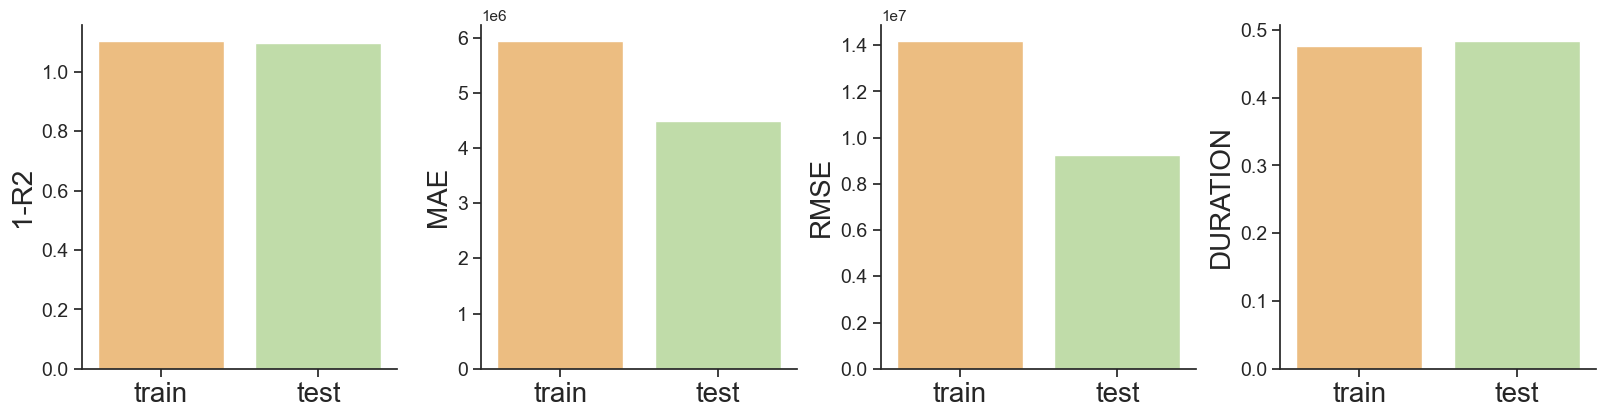

In [1141]:
from sklearn import dummy
dum_log = dummy.DummyRegressor(strategy='mean')
# Entraînement
dum_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(dum_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(dum_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_dum_log = pd.DataFrame({
    "Modele" : ["dum_log", "dum_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_dum_log, x="Data", y=df_FEATURES_dum_log[c], palette = "Spectral")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()



<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.4.4 Optimisation Gridsearch</h3>
</div>

In [1142]:
# Select an algorithm
algorithm = KNeighborsRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_neighbors': [2,3,4,5,6,7,8,9,10]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.2544273891598621
KNeighborsRegressor(n_neighbors=10)
{'n_neighbors': 10}


<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.4.5. Entrainement et prédiction optimisée</h3>
</div>

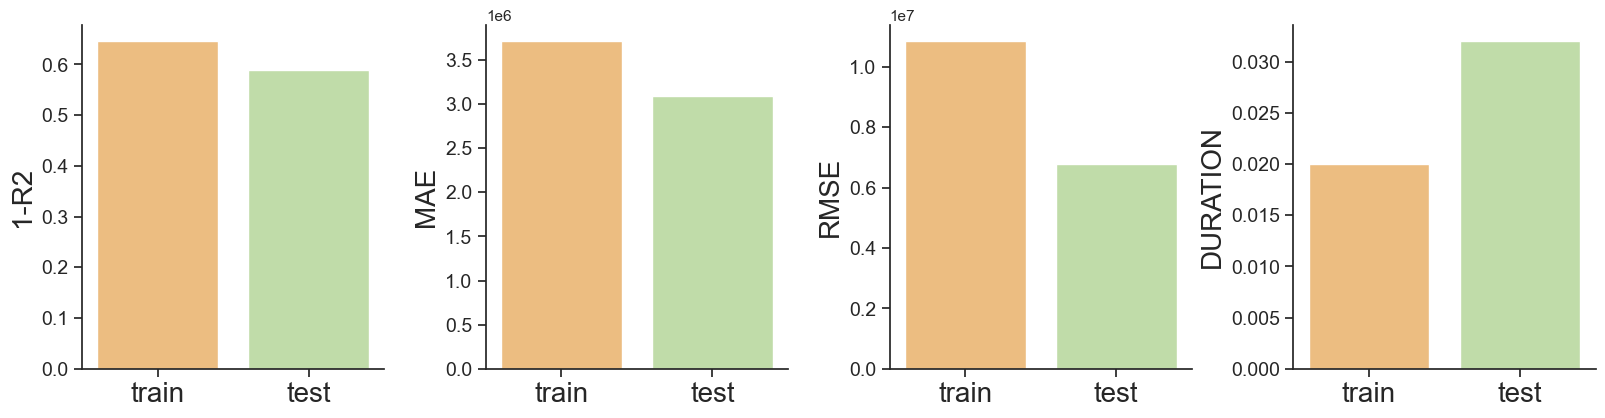

In [1143]:
from sklearn import neighbors
knn_sec_log = neighbors.KNeighborsRegressor(n_neighbors=10)
start_time_model = timeit.default_timer()
knn_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(knn_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(knn_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_knn_sec_log = pd.DataFrame({
    "Modele" : ["knn_sec_log", "knn_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_knn_sec_log, x="Data", y=df_FEATURES_knn_sec_log[c], palette = "Spectral")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

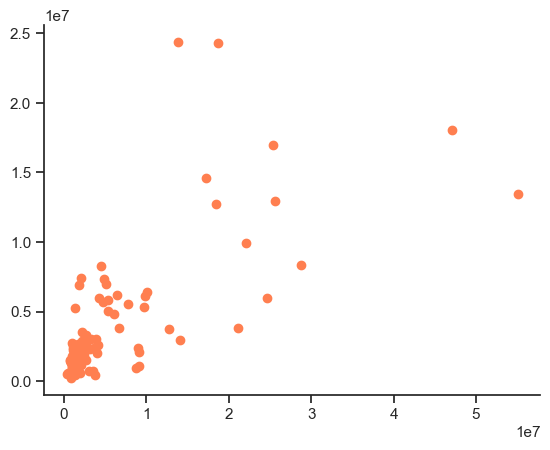

In [1144]:
plt.scatter(y_test_raw, y_pred_test_raw, color='coral')

In [1145]:
#sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
#for (yt, yp) in zip(list(y_test), list(y_pred)):
#    if (yt, yp) in sizes:
#        sizes[(yt, yp)] += 1
#    else:
#        sizes[(yt, yp)] = 1

#keys = sizes.keys()
#plt.scatter(
#        [k[0] for k in keys], # vraie valeur (abscisse)
#        [k[1] for k in keys], # valeur predite (ordonnee)
#        s=[sizes[k] for k in keys], # taille du marqueur
#        color='coral', alpha =0.8)


In [1146]:
y_pred_random = np.random.randint(np.min(y_train_raw), np.max(y_train_raw), y_test_raw.shape)

c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [1147]:
print("R2SCORE :  {:.2f}".format(round(1-r2_score(y_test, y_pred_random), 3)))
print("MAE :  {:.2f}".format(round(metrics.mean_absolute_error(y_test, y_pred_random), 3)))
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_random))))


R2SCORE :  104.06
MAE :  75775942.41
RMSE : 90297234.28


In [1148]:
#L'algorithme des k plus proches voisins est meilleur qu'une prédiction aléatoire

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5. Modélisation 2 : Regression linéaire </h3>
</div>

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.1 Entrainement de la régression linéaire baseline </h3>
</div>

In [1149]:
#La première étape est d'effectuer une régression linéaire classique 
#afin de récupérer une erreur baseline, qu'on souhaite améliorer à l'aide des techniques de régularisation.
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train_log, y_train_log)

LinearRegression()

In [1150]:
#On obtient la moyenne des erreurs quadratiques ci-dessous
import numpy as np
baseline_error = np.mean ((lr.predict(X_test_log) - y_test_log) ** 2)
print (baseline_error)

SiteEnergyUseWN(kBtu)   0.44
dtype: float64


c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [1151]:
#on doit trouver un coefficient de régularisation adapté. Pour rappel, l'objectif est de 
#biaiser un peu la prédiction, afin de diminuer l'erreur standard. 

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.2 Régression ridge </h3>
</div>

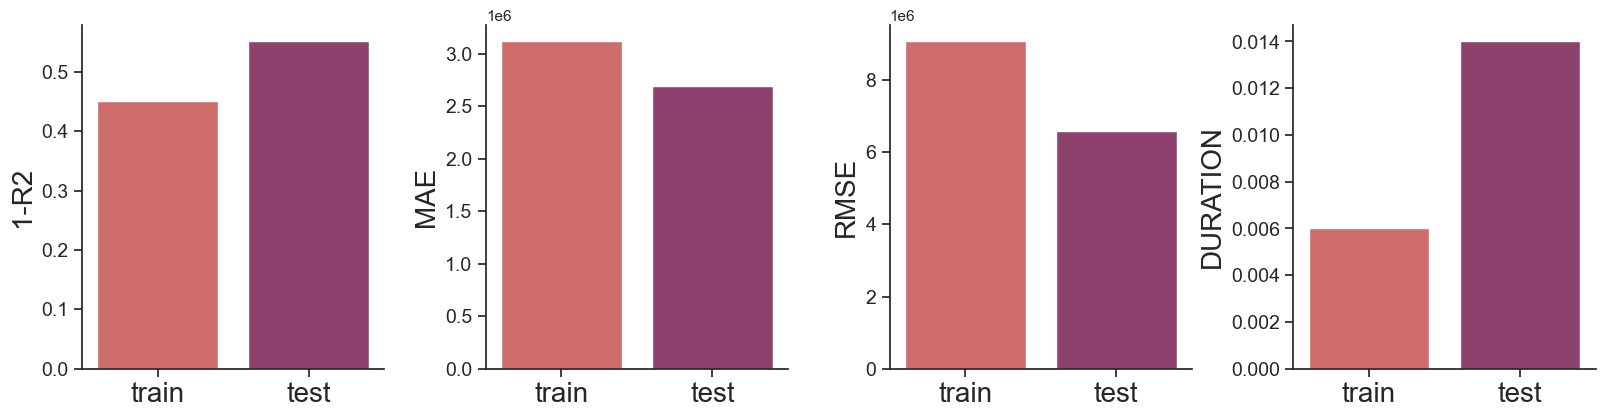

In [1152]:
# Create model
from sklearn.linear_model import Ridge

ridge_first_log = Ridge(alpha=10, random_state=n_random)
start_time_model = timeit.default_timer()
ridge_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(ridge_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(ridge_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_ridge_first_log = pd.DataFrame({
    "Modele" : ["ridge_first_log", "ridge_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_ridge_first_log, x="Data", y=df_FEATURES_ridge_first_log[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.2.1 Entrainement</h3>
</div>

In [1153]:
#On appelle ce coefficient alpha, on va 
#en tester un certain nombre afin de trouver celui qui est optimal
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
errors = []

for a in alphas:
    ridge_first_log.set_params(alpha=a)
    ridge_first_log.fit(X_train_log, y_train_log)
    coefs.append(ridge_first_log.coef_)
    errors.append(np.mean((ridge_first_log.predict(X_test_log) - y_test_log) ** 2))

c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Camille B\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\Camille B\

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.2.2 Prédiction sur le jeu test </h3>
</div>

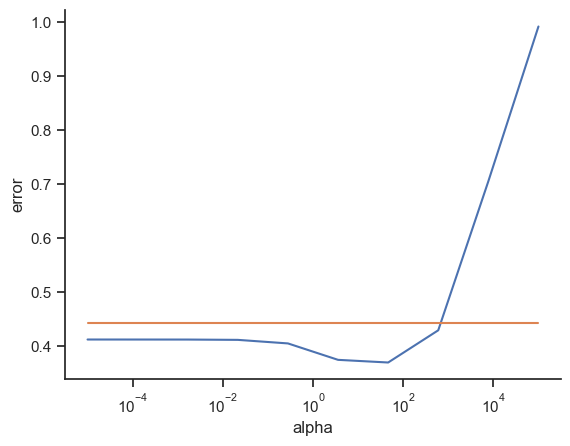

In [1154]:
import matplotlib.pyplot as plt

ax = plt.gca()

ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.2.3 Evaluation </h3>
</div>

In [1155]:
#on récupere l'index de l'erreur la plus petite 5
np.argmin(errors)

6

In [1156]:
#l'erreur la plus petite est 0.0038, l'erreur baseline était de 0.0039
errors[np.argmin(errors)]

SiteEnergyUseWN(kBtu)   0.37
dtype: float64

In [1157]:
#Ce parametre de régulation sur notre jeu test et entrainement, a permis de réduit l'erreur quadratique
#On récupere la valeur de l'alpha correspondante = 3.59
alphas[5]

3.593813663804626

In [1158]:
#On peut afficher l'évolution de la valeur des différents poids 
#associés aux paramètres
#ax = plt.gca()

#ax.plot(alphas, coefs)
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('weights')
#plt.title('Ridge coefficients as a function of the regularization')
#plt.axis('tight')
#plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.2.4 Optimisation RidgeCV </h3>
</div>

In [1159]:
# Select an algorithm
algorithm = Ridge()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'alpha': [1,5,10,15,20,25,50,100]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.4023332509639112
Ridge(alpha=50)
{'alpha': 50}


<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.2.5 Entraînement et prédiction optimisée </h3>
</div>

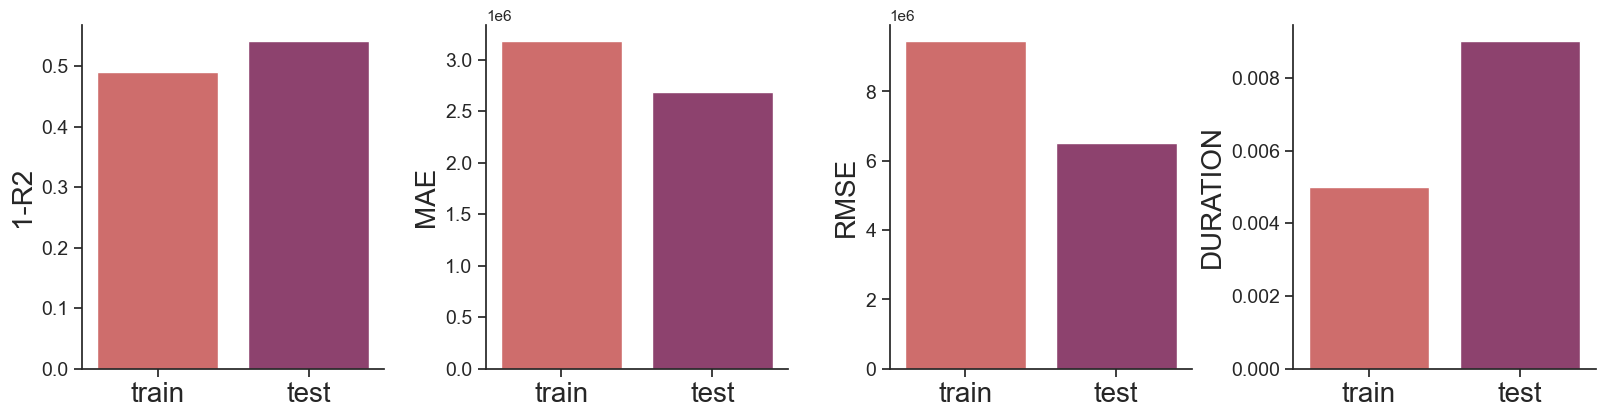

In [1160]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

ridge_sec_log = Ridge(alpha=50, random_state=n_random)
start_time_model = timeit.default_timer()
ridge_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(ridge_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(ridge_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_ridge_sec_log = pd.DataFrame({
    "Modele" : ["ridge_sec_log", "ridge_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_ridge_sec_log, x="Data", y=df_FEATURES_ridge_sec_log[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1161]:
# Create a function to plot the magnitude of coefficients on a log scale
def plotCoef(model, info=""):
    # Plot the coeffients as bars
    fig = plt.figure(figsize=(15,4))
    fig.suptitle(type(model).__name__ + " " + info, fontsize=16)
    rects = plt.bar(np.arange(len(model.coef_)), model.coef_, color="lightblue")

    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.yscale('symlog')
    plt.show()

In [1162]:
# Visualise linear regression coefficients
#plotCoef(lr)

In [1163]:
# Visualise Ridge regression coefficients for different alphas
#coefs_r = []
#for alpha in range(50,70, 1):
    # Create model
#    model = Ridge(alpha=alpha, random_state=n_random)

    #Fit model
#    model.fit(X_train, y_train)
#    predictions = model.predict(X_train)
#    print("Train:", r2_score(y_train, predictions))

    # Evaluate
#    predictions = model.predict(X_test)
#    print("Test:", r2_score(y_test, predictions))
    
#    plotCoef(model, "alpha="+str(alpha))
#    coefs_r.append(model.coef_)

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.3 Régression linéaire Lasso</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.770e+02, tolerance: 1.893e+01
  model = cd_fast.enet_coordinate_descent(


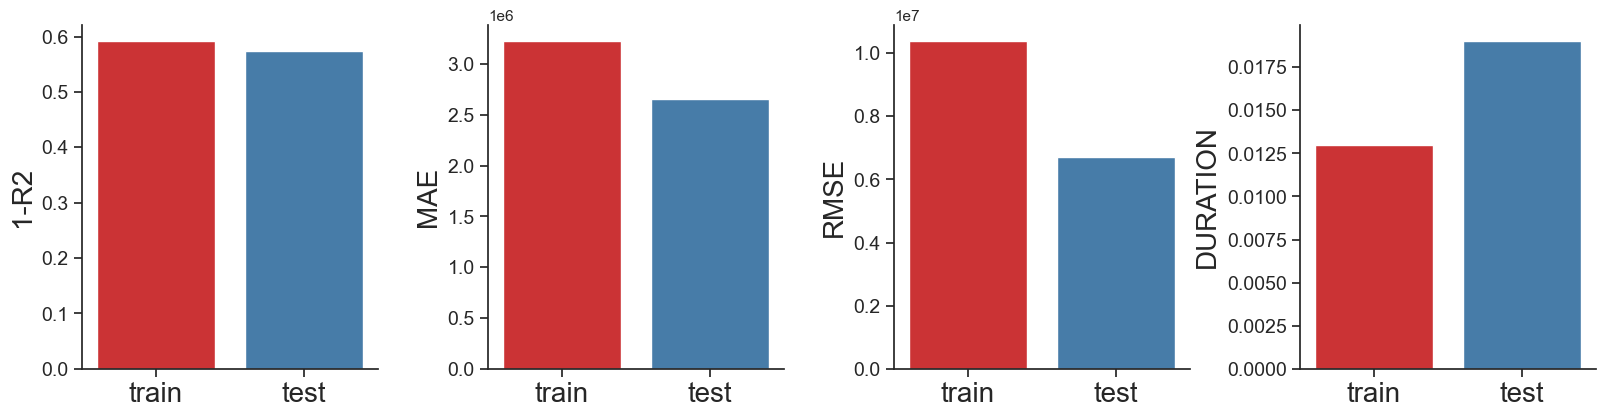

In [1164]:
# Create model
lasso_first_log = Lasso(alpha=0.002, fit_intercept=False, random_state=n_random)
start_time_model = timeit.default_timer()
lasso_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(lasso_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(lasso_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_lasso_first_log = pd.DataFrame({
    "Modele" : ["lasso_first_log", "lasso_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_lasso_first_log, x="Data", y=df_FEATURES_lasso_first_log[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()


<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.3.2 Prédiction sur le jeu test</h3>
</div>

In [1165]:
#On teste aussi un certain nombre d'hyperparamètres pour appliquer le lasso
#n_alphas = 50
#alphas = np.logspace(-5, 5, n_alphas)

#coefs = []
#errors = []
#for a in alphas:
#    lasso_first_log.set_params(alpha=a)
#    lasso_first_log.fit(X_train_log, y_train_log)
#    coefs.append(lasso_first_log.coef_)
#    errors.append([baseline_error, np.mean((lasso_first_log.predict(X_test_log) - y_test_log) ** 2)])

In [1166]:
#ax = plt.gca()

#ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('error')
#plt.axis('tight')
#plt.show()

In [1167]:
#on récupere l'index de l'erreur la plus petite 11
#np.argmin(errors)

In [1168]:
#l'erreur la plus petite est 0.00045, l'erreur baseline était de 0.0066
#errors [np.argmin(errors)] 

In [1169]:
#Ce parametre de régulation sur notre jeu test et entrainement, a permis de réduit l'erreur quadratique

In [1170]:
#On récupere la valeur de l'alpha correspondante = 
#alphas['0.00045']

In [1171]:
#On peut maintenant afficher les résultats
#ax = plt.gca()

#ax.plot(alphas, coefs)
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('weights')
#plt.axis('tight')
#plt.show()


<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.3.4 Optimisation Lasso CV </h3>
</div>

In [1172]:
# Select an algorithm
algorithm = Lasso()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'alpha': [1,5,10,15,20,25,50,100]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.04785278734874088
Lasso(alpha=1)
{'alpha': 1}


<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.3.5 Entrainemement et prédiction optimisée</h3>
</div>

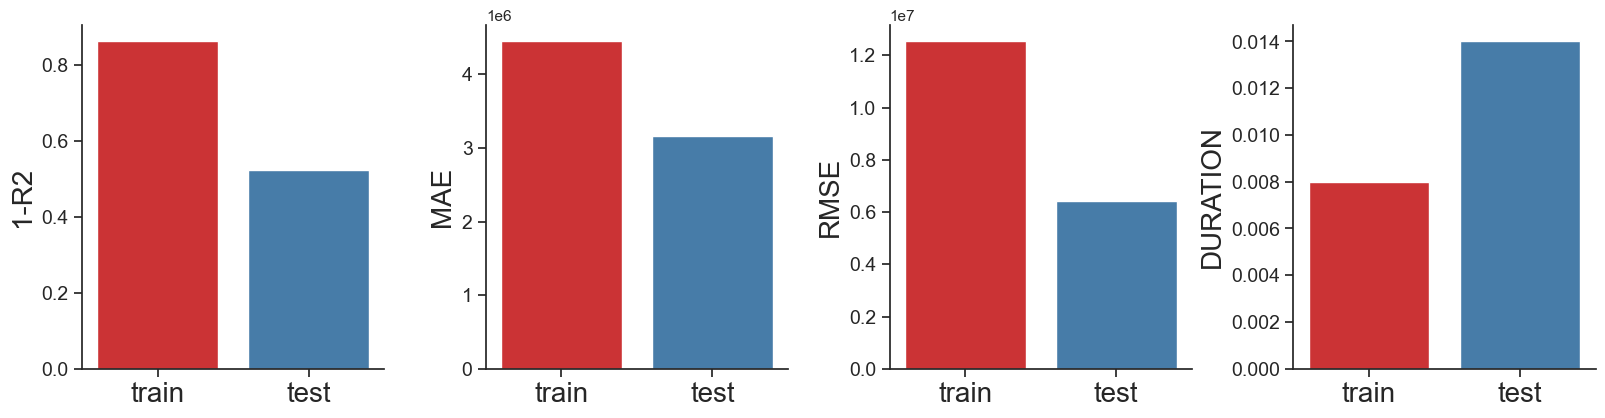

In [1173]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

lasso_sec_log = Lasso(alpha=1, fit_intercept=False, random_state=n_random)
start_time_model = timeit.default_timer()
lasso_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(lasso_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(lasso_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_lasso_sec_log = pd.DataFrame({
    "Modele" : ["lasso_sec_log", "lasso_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_lasso_sec_log, x="Data", y=df_FEATURES_lasso_sec_log[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1174]:
# Visualise Lasso regression coefficients for different alphas
#coefs_l = []
#for alpha in range(0, 2):
    # Create model
#    model = Lasso(alpha=alpha, random_state=n_random)

    #Fit model
#    model.fit(X_train, y_train)
#    predictions = model.predict(X_train)
#    print("Train:", r2_score(y_train, predictions))

    # Evaluate
#    predictions = model.predict(X_test)
#    print("Test:", r2_score(y_test, predictions))
    
#    plotCoef(model, "alpha="+str(alpha))
#    coefs_l.append(model.coef_)

In [1175]:
#Examination to show that the increase in alpha reduces the total magnitude of the coefficients
#Prove that Ridge is reducing overall magnitude of coeficients with increasing alpha
#Should return an array of diminishing values
#np.sum(abs(np.array(coefs_r)), axis=1)

In [1176]:
#Prove that Lasso is reducing overall magnitude of coeficients with increasing alpha
#Should return an array of diminishing values
#np.sum(abs(np.array(coefs_l)), axis=1)

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.4 ElasticNet</h3>
</div>

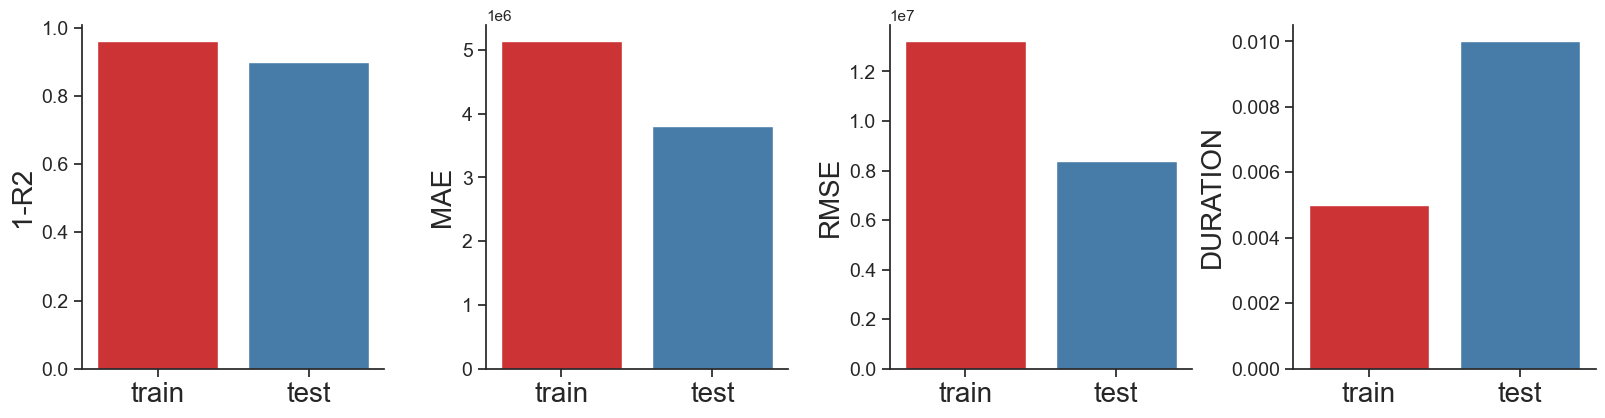

In [1177]:
from sklearn.linear_model import ElasticNet
from time import time

elnet_first_log = ElasticNet(alpha=1, l1_ratio=0.5, random_state=n_random)
start_time_model = timeit.default_timer()
elnet_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(elnet_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(elnet_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_elnet_first_log = pd.DataFrame({
    "Modele" : ["elnet_first_log", "elnet_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_elnet_first_log, x="Data", y=df_FEATURES_elnet_first_log[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1178]:
# Select an algorithm
algorithm = ElasticNet()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'alpha': [1,5,10,15,20,25,50,100]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.19279441342681108
ElasticNet(alpha=1)
{'alpha': 1}


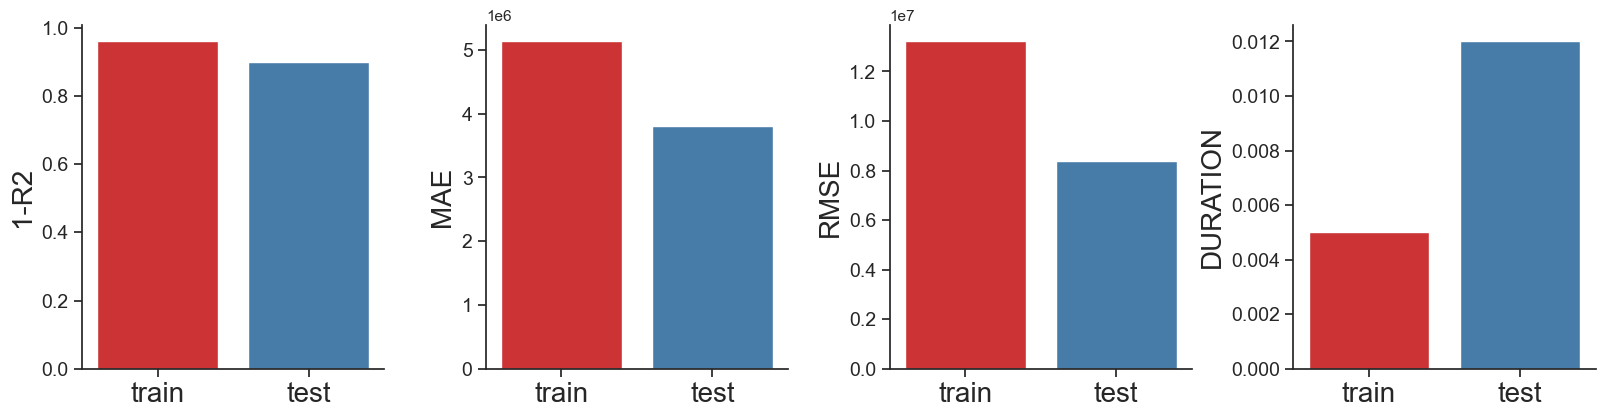

In [1179]:
from sklearn.linear_model import ElasticNet
from time import time

elnet_sec_log = ElasticNet(alpha=1, l1_ratio=0.5, random_state=n_random)
start_time_model = timeit.default_timer()
elnet_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(elnet_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(elnet_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_elnet_sec_log = pd.DataFrame({
    "Modele" : ["elnet_sec_log", "elnet_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_elnet_sec_log, x="Data", y=df_FEATURES_elnet_sec_log[c], palette = "Set1")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.5.5 SVR</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


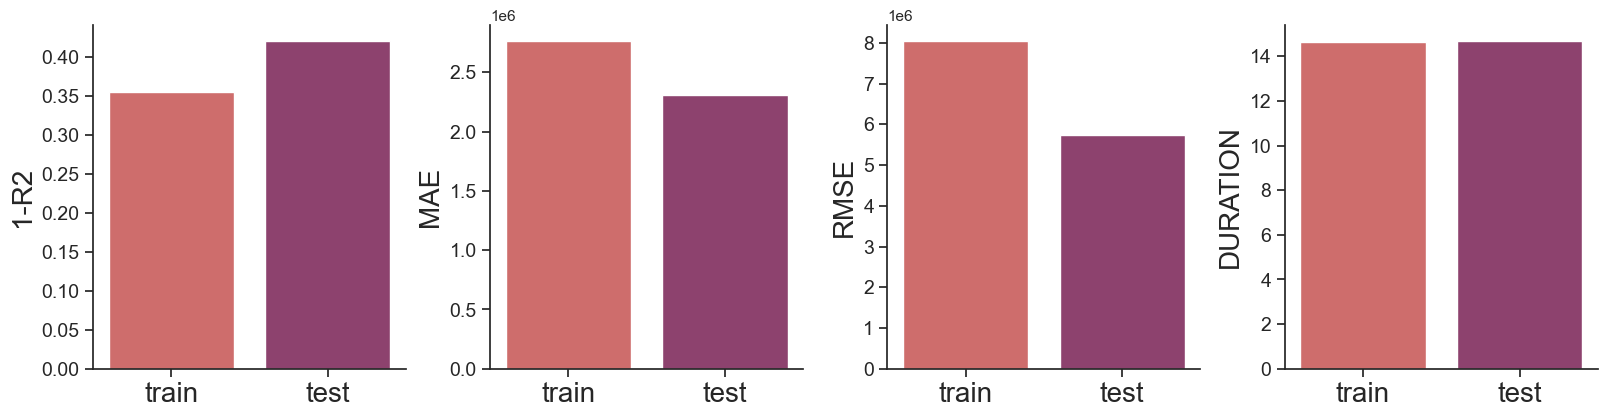

In [1180]:
from sklearn.svm import LinearSVR
svr_first_log = SVR(kernel="linear", C=200, gamma="auto")
start_time_model = timeit.default_timer()
svr_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(svr_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(svr_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_svr_first_log = pd.DataFrame({
    "Modele" : ["svr_first_log", "svr_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_svr_first_log, x="Data", y=df_FEATURES_svr_first_log[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1181]:
# Select an algorithm
algorithm = SVR()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'C': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

0.4523325449417971
SVR(C=500)
{'C': 500}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


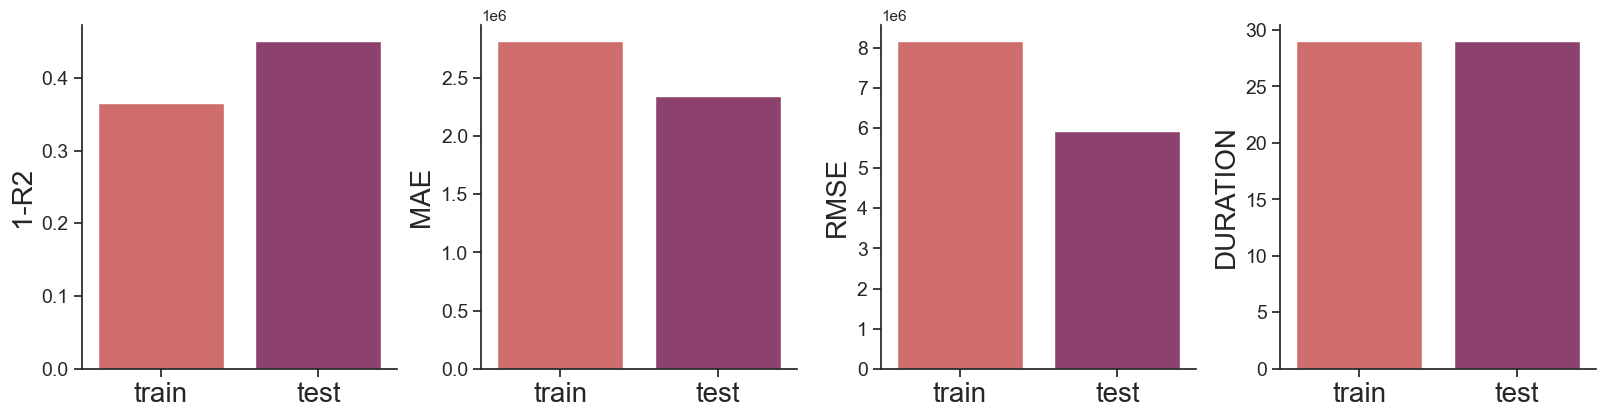

In [1182]:
from sklearn.svm import LinearSVR
svr_sec_log = SVR(kernel="linear", C=500, gamma="auto")
start_time_model = timeit.default_timer()
svr_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(svr_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(svr_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_svr_sec_log = pd.DataFrame({
    "Modele" : ["svr_sec_log", "svr_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_svr_sec_log, x="Data", y=df_FEATURES_svr_sec_log[c], palette = "flare")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.6. BAGGING</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


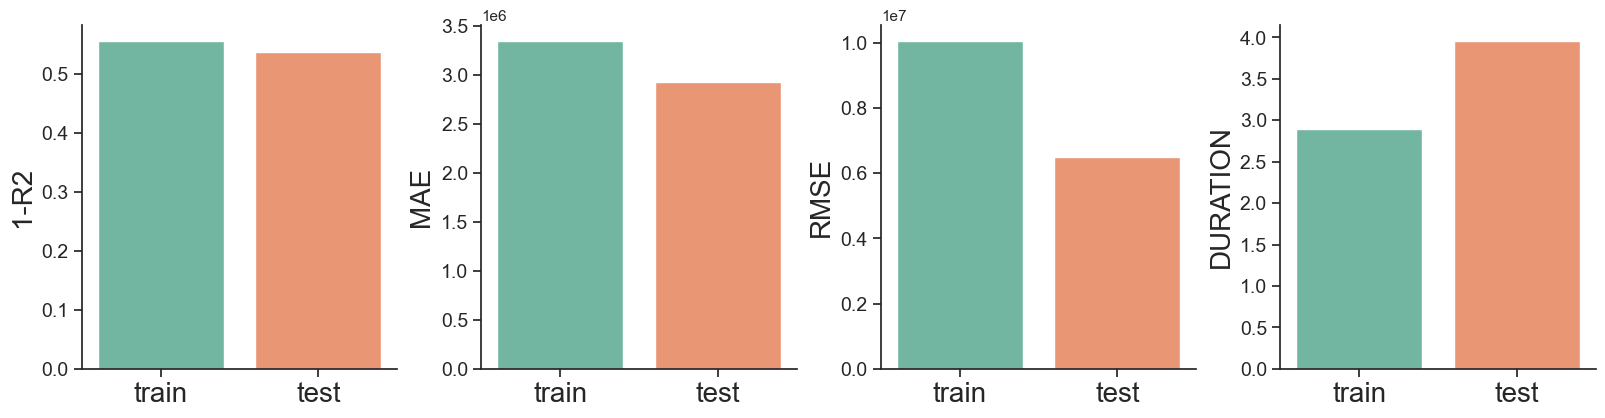

In [1183]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

bagregr_first_log = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=200, random_state=n_random)
start_time_model = timeit.default_timer()
bagregr_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(bagregr_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(bagregr_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_bagregr_first_log = pd.DataFrame({
    "Modele" : ["bagregr_first_log", "bagregr_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_bagregr_first_log, x="Data", y=df_FEATURES_bagregr_first_log[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1184]:
# Select an algorithm
algorithm = BaggingRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

0.3389382237790404
BaggingRegressor(n_estimators=500)
{'n_estimators': 500}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


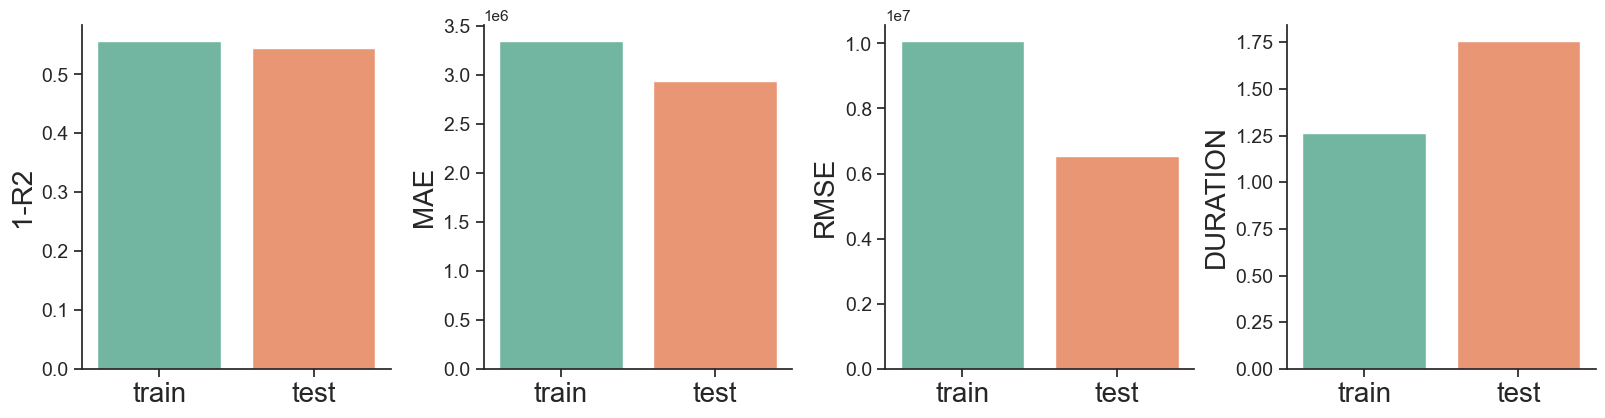

In [1185]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

bagregr_sec_log = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=100, random_state=n_random)
start_time_model = timeit.default_timer()
bagregr_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(bagregr_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(bagregr_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_bagregr_sec_log = pd.DataFrame({
    "Modele" : ["bagregr_sec_log", "bagregr_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_bagregr_sec_log, x="Data", y=df_FEATURES_bagregr_sec_log[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\3841334267.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforegr_first_log.fit(X_train_log, y_train_log)


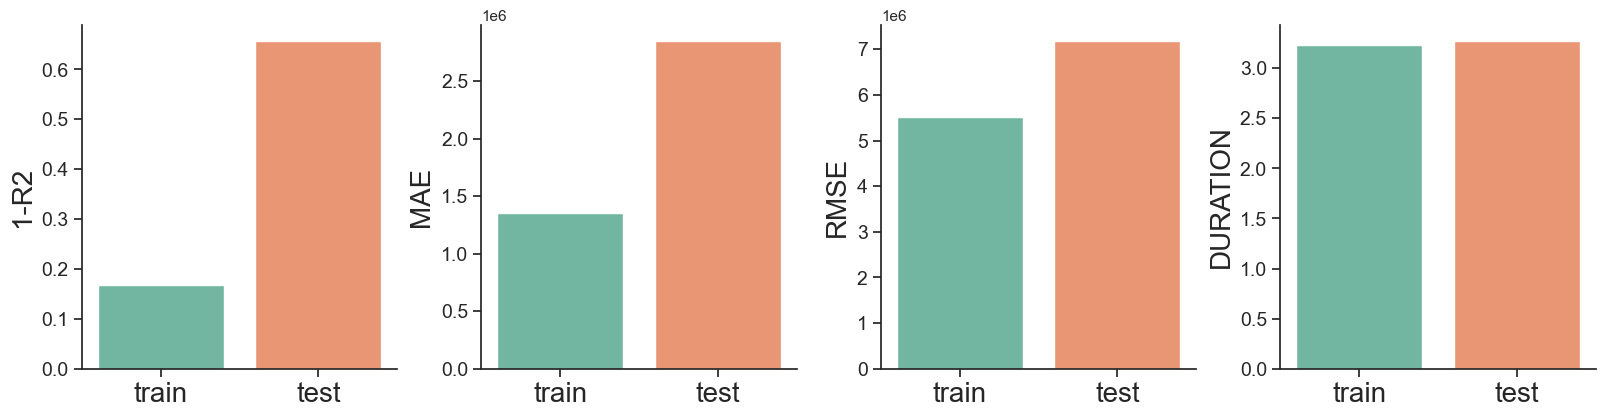

In [1186]:
rforegr_first_log = RandomForestRegressor(n_estimators = 500, random_state=n_random)
start_time_model = timeit.default_timer()
rforegr_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(rforegr_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(rforegr_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_rforegr_first_log = pd.DataFrame({
    "Modele" : ["rforegr_first_log", "rforegr_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_rforegr_first_log, x="Data", y=df_FEATURES_rforegr_first_log[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1187]:
# Select an algorithm
algorithm = RandomForestRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A co

0.33689506377445444
RandomForestRegressor()
{'n_estimators': 100}


C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\4111294093.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforegr_sec_log.fit(X_train_log, y_train_log)


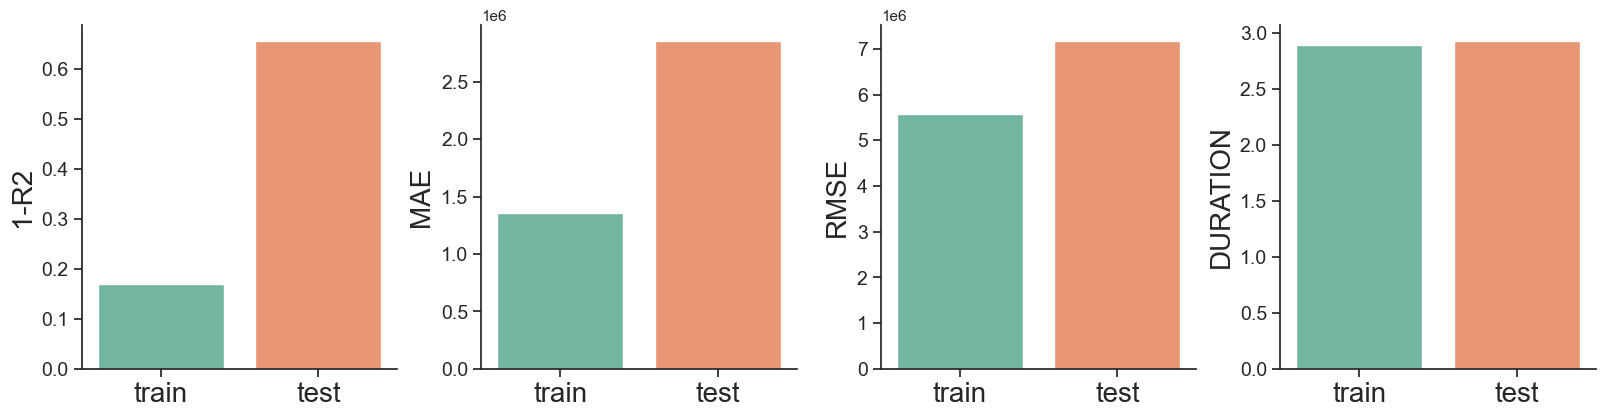

In [1188]:
rforegr_sec_log = RandomForestRegressor(n_estimators = 400, random_state=n_random)
start_time_model = timeit.default_timer()
rforegr_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(rforegr_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(rforegr_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_rforegr_sec_log = pd.DataFrame({
    "Modele" : ["rforegr_sec_log", "rforegr_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_rforegr_sec_log, x="Data", y=df_FEATURES_rforegr_sec_log[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: red;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">B.7. BOOSTING</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


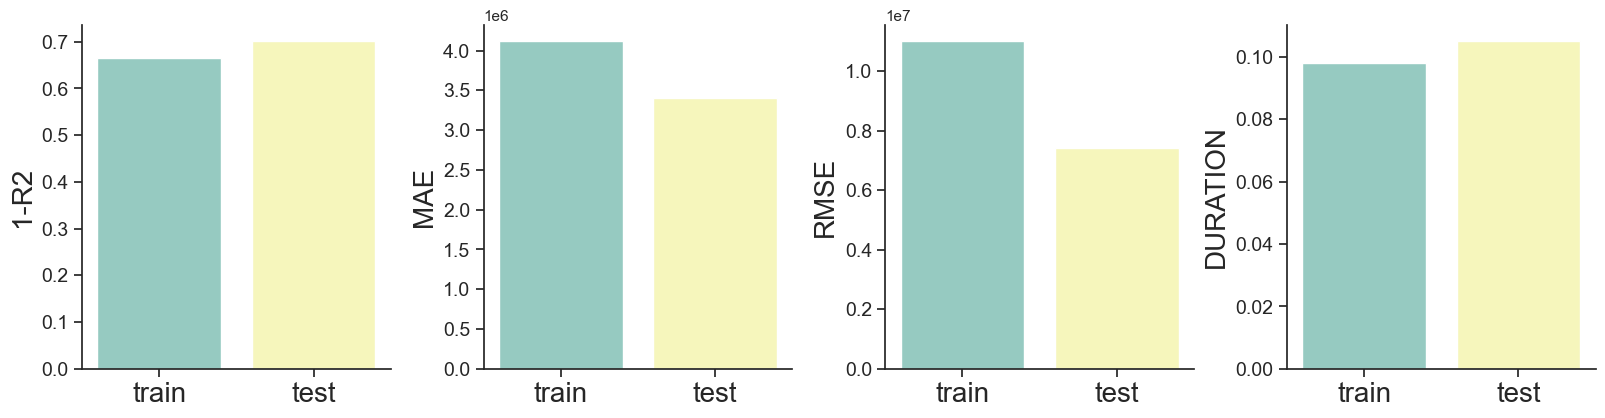

In [1189]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
adaboostregr_first_log = AdaBoostRegressor(n_estimators = 100, random_state=n_random)
start_time_model = timeit.default_timer()
adaboostregr_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(adaboostregr_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(adaboostregr_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_adaboostregr_first_log = pd.DataFrame({
    "Modele" : ["adaboostregr_first_log", "adaboostregr_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_adaboostregr_first_log, x="Data", y=df_FEATURES_adaboostregr_first_log[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1190]:
# Select an algorithm
algorithm = AdaBoostRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [50,100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

0.24232244719436702
AdaBoostRegressor()
{'n_estimators': 50}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


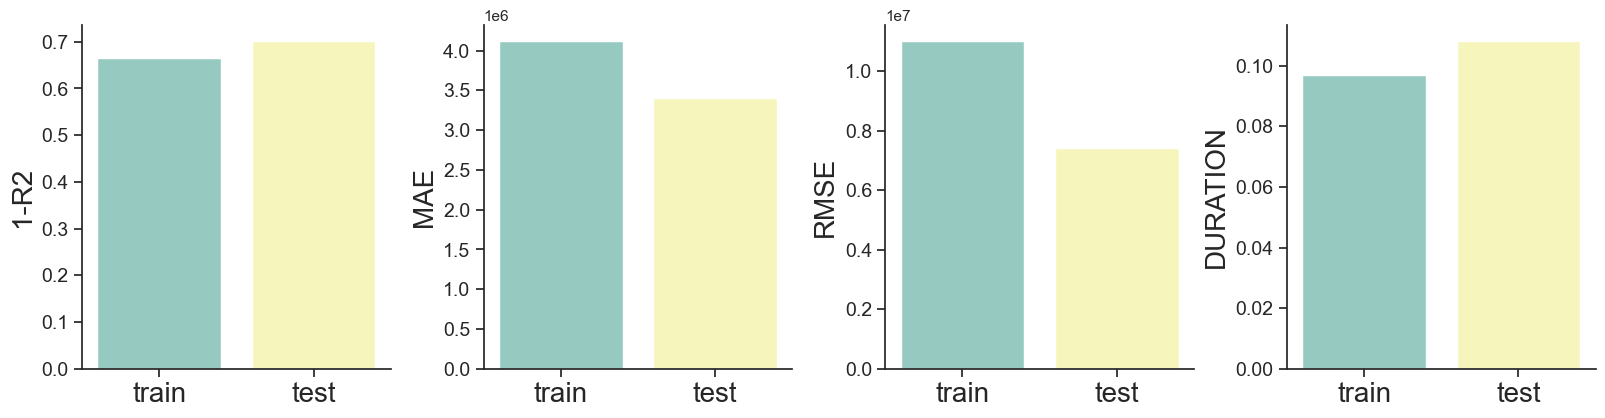

In [1191]:
adaboostregr_sec_log = AdaBoostRegressor(n_estimators = 400, random_state=n_random)
start_time_model = timeit.default_timer()
adaboostregr_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(adaboostregr_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(adaboostregr_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_adaboostregr_sec_log = pd.DataFrame({
    "Modele" : ["adaboostregr_sec_log", "adaboostregr_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_adaboostregr_sec_log, x="Data", y=df_FEATURES_adaboostregr_sec_log[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


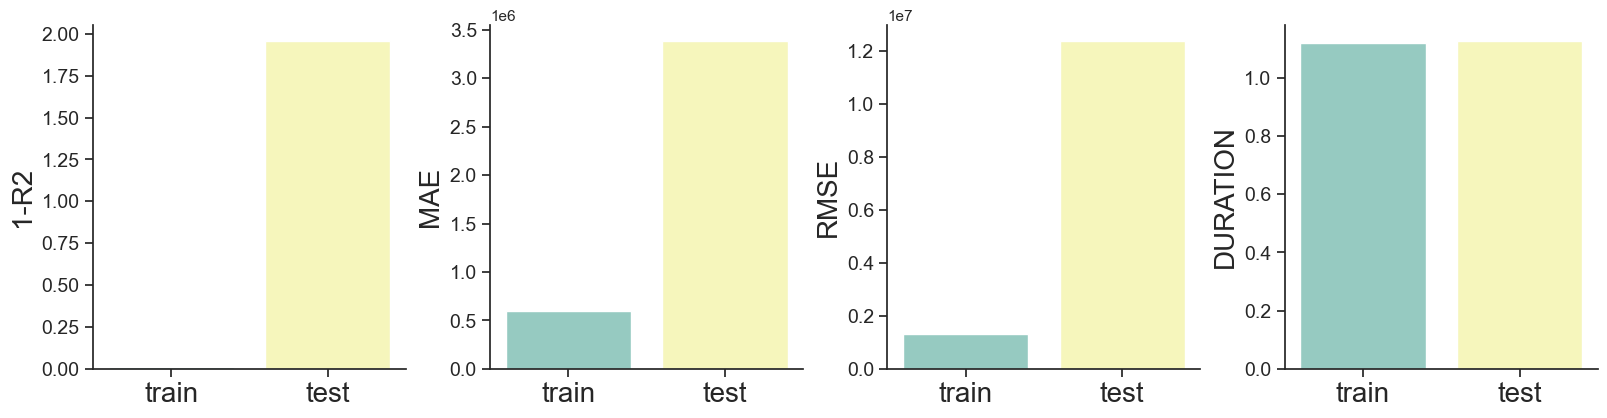

In [1192]:
gboostregr_first_log = GradientBoostingRegressor(n_estimators = 500, random_state=n_random)
start_time_model = timeit.default_timer()
gboostregr_first_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(gboostregr_first_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(gboostregr_first_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_gboostregr_first_log = pd.DataFrame({
    "Modele" : ["gboostregr_first_log", "gboostregr_first_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_gboostregr_first_log, x="Data", y=df_FEATURES_gboostregr_first_log[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1193]:
# Select an algorithm
algorithm = GradientBoostingRegressor()

# Create 3 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=n_random)

# Define our candidate hyperparameters
hp_candidates = [{'n_estimators': [100,200,300,400,500]}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X_train_log, y_train_log)

# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.30006475688628875
GradientBoostingRegressor()
{'n_estimators': 100}


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


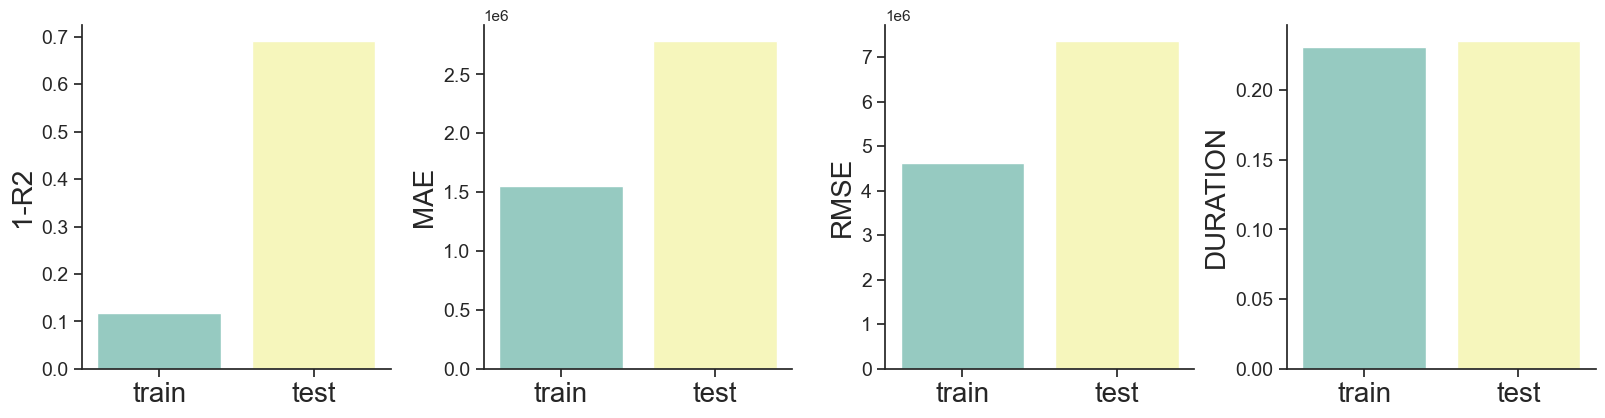

In [1194]:
gboostregr_sec_log = GradientBoostingRegressor(n_estimators = 100, random_state=n_random)
start_time_model = timeit.default_timer()
gboostregr_sec_log.fit(X_train_log, y_train_log)

# Making the prediction using the training data
y_pred_train_std = pd.DataFrame(gboostregr_sec_log.predict(X_train_log), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(np.exp(X_train_log)-1)
y_train_raw = pd.DataFrame(np.exp(y_train_log)-1)
y_pred_train_raw = pd.DataFrame(np.exp(y_pred_train_std)-1)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the testing data
y_pred_test_std = pd.DataFrame(gboostregr_sec_log.predict(X_test_log), index=y_test.index, columns=y_test.columns)
end_time_model_test =  round(timeit.default_timer() - start_time_model, 3)
X_test_raw = pd.DataFrame(np.exp(X_test_log)-1)
y_test_raw = pd.DataFrame(np.exp(y_test_log)-1)
y_pred_test_raw = pd.DataFrame(np.exp(y_pred_test_std)-1)
R2SCORE_test = round((1-r2_score(y_test_raw, y_pred_test_raw)), 5)
MAE_test = round(mean_absolute_error(y_test_raw, y_pred_test_raw), 3)
RMSE_test = round(mean_squared_error(y_test_raw, y_pred_test_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_test] 
MAE = [MAE_train, MAE_test]
RMSE = [RMSE_train, RMSE_test]
DURATION = [end_time_model_train, end_time_model_test]

df_FEATURES_gboostregr_sec_log = pd.DataFrame({
    "Modele" : ["gboostregr_sec_log", "gboostregr_sec_log"],
    "Data" : ["train", "test"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_gboostregr_sec_log, x="Data", y=df_FEATURES_gboostregr_sec_log[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

<div style="background-color: pink;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">COMPARAISON MODELES</h3>
</div>

In [1195]:
df_final_energy_log = pd.concat([df_FEATURES_knn_first_log, df_FEATURES_knn_sec_log, 
                             df_FEATURES_ridge_first_log, df_FEATURES_ridge_sec_log,
                             df_FEATURES_lasso_first_log, df_FEATURES_lasso_sec_log, 
                             df_FEATURES_elnet_first_log, df_FEATURES_elnet_sec_log,
                             df_FEATURES_svr_first_log, df_FEATURES_svr_sec_log, 
                             df_FEATURES_bagregr_first_log, df_FEATURES_bagregr_sec_log,
                             df_FEATURES_rforegr_first_log, df_FEATURES_rforegr_sec_log, 
                             df_FEATURES_adaboostregr_first_log, df_FEATURES_adaboostregr_sec_log,
                             df_FEATURES_gboostregr_first_log, df_FEATURES_gboostregr_sec_log], axis=0)
df_final_energy_log

,Modele,Data,1-R2,MAE,RMSE,DURATION
0,knn_first_log,train,0.25,2134493.74,6771089.78,0.02
1,knn_first_log,test,0.53,2939417.31,6414193.31,0.04
0,knn_sec_log,train,0.65,3710520.00,10838174.01,0.02
1,knn_sec_log,test,0.59,3094794.78,6788227.24,0.03
0,ridge_first_log,train,0.45,3117799.68,9063966.42,0.01
1,ridge_first_log,test,0.55,2692031.75,6570151.68,0.01
0,ridge_sec_log,train,0.49,3179150.83,9442153.45,0.01
1,ridge_sec_log,test,0.54,2688255.73,6510961.51,0.01
0,lasso_first_log,train,0.59,3222284.53,10374759.85,0.01
1,lasso_first_log,test,0.57,2650988.47,6702517.26,0.02


In [1196]:
df_final = pd.concat([df_final_energy_log, df_final_energy], axis=0)

In [1197]:
df_final

,Modele,Data,1-R2,MAE,RMSE,DURATION
0,knn_first_log,train,0.25,2134493.74,6771089.78,0.02
1,knn_first_log,test,0.53,2939417.31,6414193.31,0.04
0,knn_sec_log,train,0.65,3710520.00,10838174.01,0.02
1,knn_sec_log,test,0.59,3094794.78,6788227.24,0.03
0,ridge_first_log,train,0.45,3117799.68,9063966.42,0.01
1,ridge_first_log,test,0.55,2692031.75,6570151.68,0.01
0,ridge_sec_log,train,0.49,3179150.83,9442153.45,0.01
1,ridge_sec_log,test,0.54,2688255.73,6510961.51,0.01
0,lasso_first_log,train,0.59,3222284.53,10374759.85,0.01
1,lasso_first_log,test,0.57,2650988.47,6702517.26,0.02


In [1198]:
after_cv = ['knn_sec','knn_sec_log', 'lasso_sec', 'lasso_sec_log', 'elnet_sec','elnet_sec_log',
'ridge_sec','ridge_sec_log','svr_sec','svr_sec_log','bagregr_sec','bagregr_sec_log', 'rforegr_sec','rforegr_sec_log',
'adaboostregr_sec','adaboostregr_sec_log','gboostregr_sec','gboostregr_sec_log']

In [1199]:
mask = ~df_final['Modele'].isin(after_cv)
df_final.loc[mask, 'Modele'] = np.NaN
df_final = df_final.dropna(axis= "rows", subset = 'Modele')
df_final_test = df_final.loc[df_final['Data'] == 'test']
df_final_test.sort_values('MAE')

,Modele,Data,1-R2,MAE,RMSE,DURATION
1,gboostregr_sec,test,0.48,1957782.01,6110528.30,0.25
1,rforegr_sec,test,0.44,2252425.71,5852252.30,2.92
1,svr_sec_log,test,0.45,2347866.34,5937446.02,28.99
1,ridge_sec_log,test,0.54,2688255.73,6510961.51,0.01
1,gboostregr_sec_log,test,0.69,2780256.01,7355205.74,0.23
1,rforegr_sec_log,test,0.65,2850910.99,7163157.81,2.92
1,bagregr_sec_log,test,0.55,2936045.60,6536997.77,1.75
1,knn_sec_log,test,0.59,3094794.78,6788227.24,0.03
1,ridge_sec,test,0.45,3157833.22,5918216.00,0.01
1,lasso_sec_log,test,0.52,3161006.49,6406676.94,0.01


In [1200]:
df_r2 = df_final_test.sort_values('1-R2')
df_mae = df_final_test.sort_values('MAE')
df_rmse = df_final_test.sort_values('RMSE')
df_duration = df_final_test.sort_values('DURATION')

Text(0.5, 0, '')

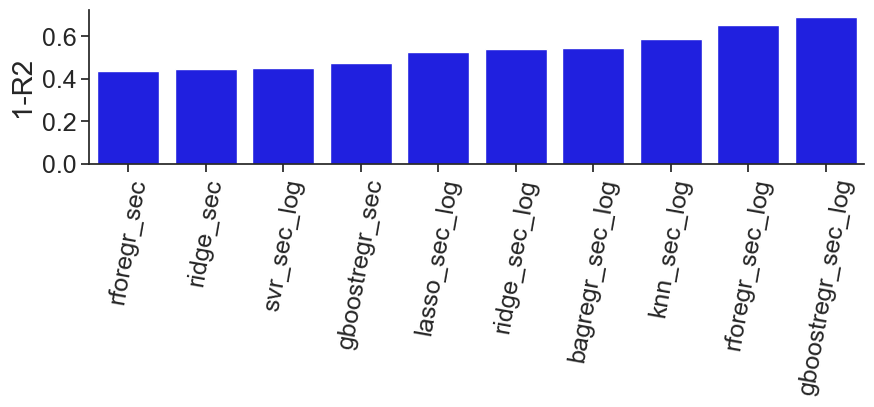

In [1201]:
plt.figure(figsize=(10, 2))
sns.barplot(data=df_r2.head(10), x="Modele", y="1-R2", color ='blue')
plt.xticks(rotation =80, fontsize=18)
plt.yticks(fontsize=18)
sns.color_palette("pastel")
plt.ylabel("1-R2", fontsize=20)
plt.xlabel("", fontsize=20)

Text(0.5, 0, '')

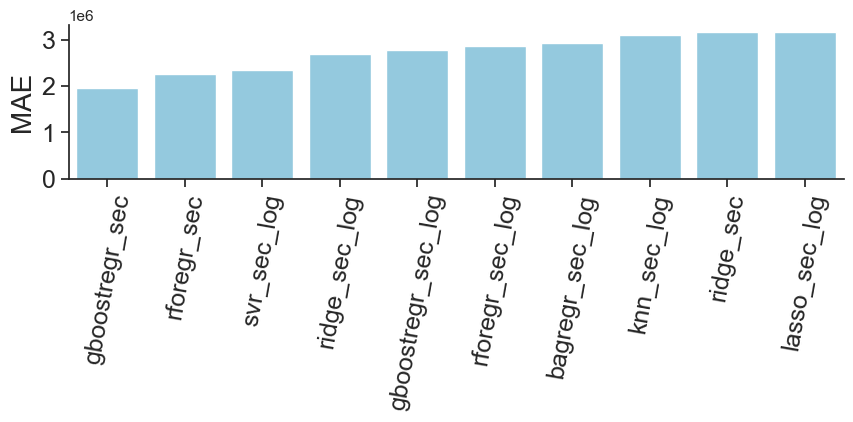

In [1202]:
plt.figure(figsize=(10, 2))
sns.barplot(data=df_mae.head(10), x="Modele", y="MAE", color ='skyblue')
plt.xticks(rotation =80, fontsize=18)
plt.yticks(fontsize=18)
sns.color_palette("pastel")
plt.ylabel("MAE", fontsize=20)
plt.xlabel("", fontsize=20)


Text(0.5, 0, '')

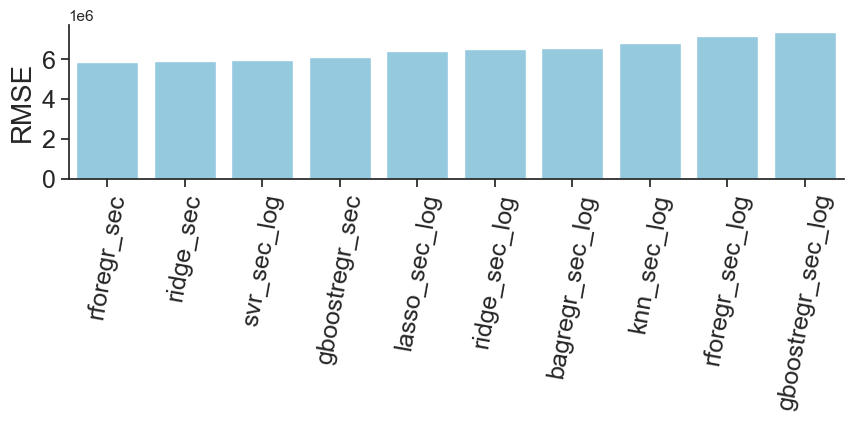

In [1203]:
plt.figure(figsize=(10, 2))
sns.barplot(data=df_rmse.head(10), x="Modele", y="RMSE", color ='skyblue')
plt.xticks(rotation =80, fontsize=18)
plt.yticks(fontsize=18)
sns.color_palette("pastel")
plt.ylabel("RMSE", fontsize=20)
plt.xlabel("", fontsize=20)

Text(0.5, 0, '')

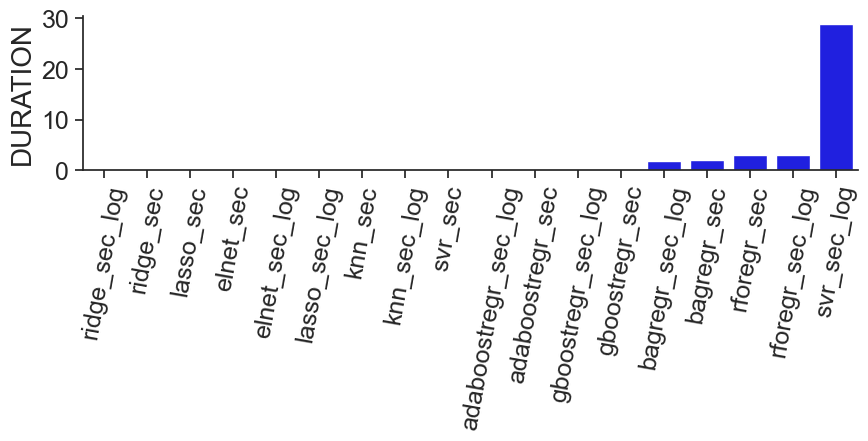

In [1204]:
plt.figure(figsize=(10, 2))
sns.barplot(data=df_duration, x="Modele", y="DURATION", color ='blue')
plt.xticks(rotation =80, fontsize=18)
plt.yticks(fontsize=18)
sns.color_palette("pastel")
plt.ylabel("DURATION", fontsize=20)
plt.xlabel("", fontsize=20)

<div style="background-color: pink;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">GradientBoostingRegressor ou randomforest ?</h3>
</div>

In [1205]:
from sklearn.model_selection import validation_curve

In [1206]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [1207]:
n_random = 20

In [1208]:
#X_train, X_temp, y_train, y_temp = train_test_split(df_X_ok, df_y_ok, shuffle=True, train_size=0.8, random_state=n_random)

In [1209]:
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_temp de forme {X_temp.shape} et y_temp de forme {y_temp.shape}")

Nous avons X_train de forme (839, 24) et y_train de forme (839, 1)
Nous avons X_temp de forme (210, 24) et y_temp de forme (210, 1)


In [1210]:
#X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, shuffle=True, test_size=0.5, random_state=n_random) #ici
#on ne touchera pas a la partie validation du dataset, seulement à la toute fin

In [1211]:
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
print(f"Nous avons X_valid de forme {X_valid.shape} et y_valid de forme {y_valid.shape}")

Nous avons X_test de forme (105, 24) et y_test de forme (105, 1)
Nous avons X_valid de forme (105, 24) et y_valid de forme (105, 1)


In [1212]:
from sklearn import preprocessing
X_std_scale = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True, clip=False).fit(X_train)
X_train_std = pd.DataFrame(X_std_scale.transform(X_train))
X_test_std = pd.DataFrame(X_std_scale.transform(X_test))
X_valid_std = pd.DataFrame(X_std_scale.transform(X_valid))

In [1213]:
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
X_test_raw = pd.DataFrame(X_std_scale.inverse_transform(X_test_std), index=X_test.index, columns=X_test.columns)
X_valid_raw = pd.DataFrame(X_std_scale.inverse_transform(X_valid_std), index=X_valid.index, columns=X_valid.columns)

In [1214]:
from sklearn import preprocessing
y_std_scale = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True, clip=False).fit(y_train)
y_train_std = pd.DataFrame(y_std_scale.transform(y_train))
y_test_std = pd.DataFrame(y_std_scale.transform(y_test))
y_valid_std = pd.DataFrame(y_std_scale.transform(y_valid))


In [1215]:
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_test_raw = pd.DataFrame(y_std_scale.inverse_transform(y_test_std), index=y_test.index, columns=y_test.columns)
y_valid_raw = pd.DataFrame(y_std_scale.inverse_transform(y_valid_std), index=y_valid.index, columns=y_valid.columns)

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


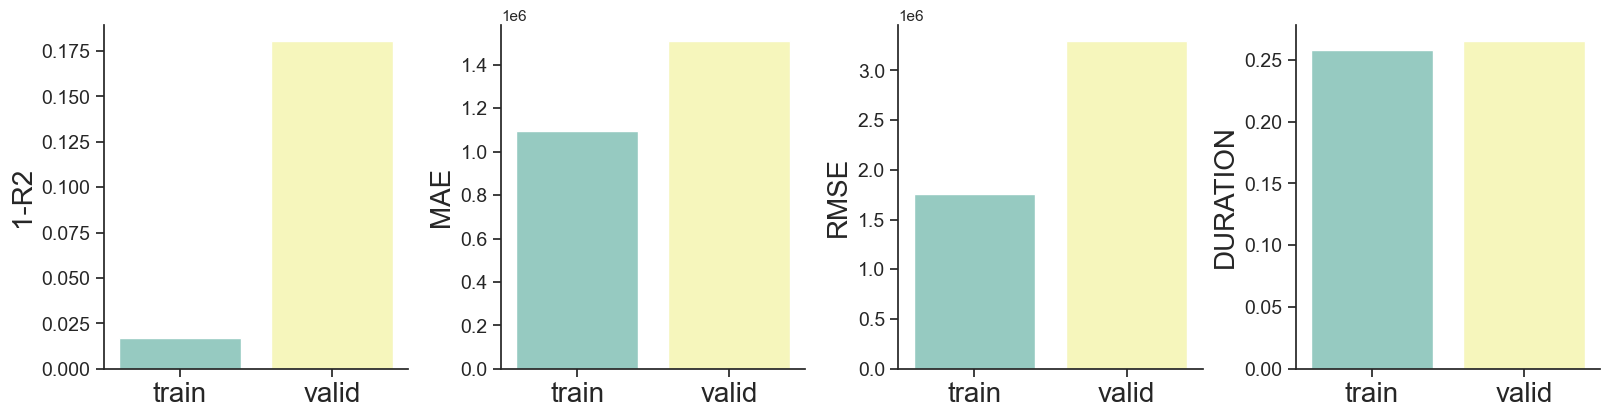

In [1216]:
gboostregr_valid = GradientBoostingRegressor(n_estimators = 100, random_state=n_random)
start_time_model = timeit.default_timer()
gboostregr_valid.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(gboostregr_valid.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the validing data
y_pred_std = pd.DataFrame(gboostregr_valid.predict(X_valid_std), index=y_valid.index, columns=y_valid.columns)
end_time_model_valid =  round(timeit.default_timer() - start_time_model, 3)
X_valid_raw = pd.DataFrame(X_std_scale.inverse_transform(X_valid_std), index=X_valid.index, columns=X_valid.columns)
y_valid_raw = pd.DataFrame(y_std_scale.inverse_transform(y_valid_std), index=y_valid.index, columns=y_valid.columns)
y_pred_valid_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_valid = round((1-r2_score(y_valid_raw, y_pred_valid_raw)), 5)
MAE_valid = round(mean_absolute_error(y_valid_raw, y_pred_valid_raw), 3)
RMSE_valid = round(mean_squared_error(y_valid_raw, y_pred_valid_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_valid] 
MAE = [MAE_train, MAE_valid]
RMSE = [RMSE_train, RMSE_valid]
DURATION = [end_time_model_train, end_time_model_valid]

df_FEATURES_gboostregr_valid = pd.DataFrame({
    "Modele" : ["gboostregr_valid", "gboostregr_valid"],
    "Data" : ["train", "valid"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_gboostregr_valid, x="Data", y=df_FEATURES_gboostregr_valid[c], palette = "Set3")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

C:\Users\Camille B\AppData\Local\Temp\ipykernel_22736\3463327971.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforegr_valid.fit(X_train_std, y_train_std)


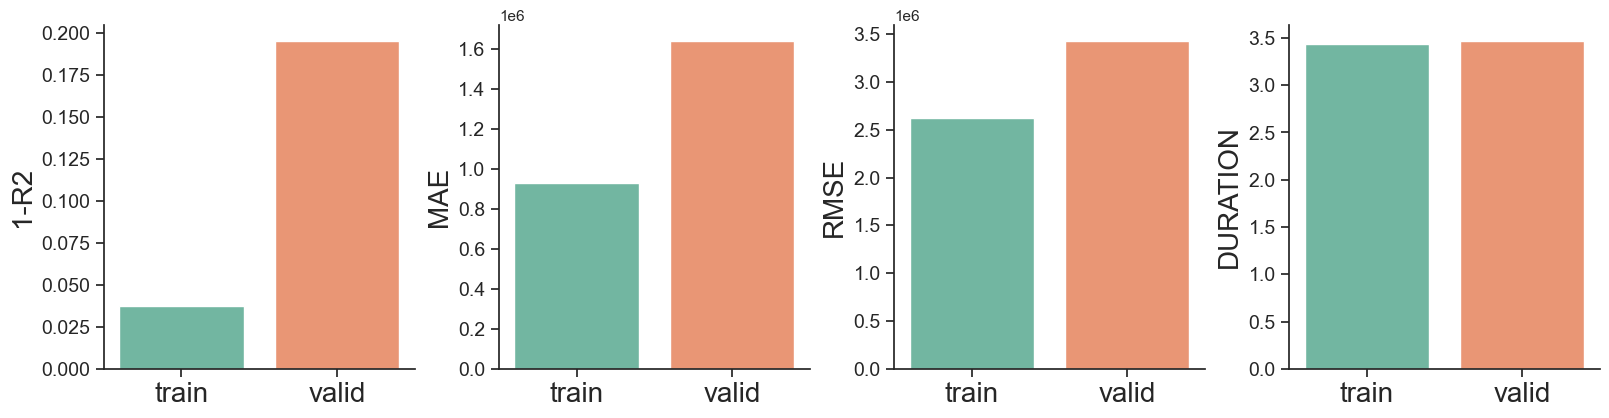

In [1217]:
rforegr_valid = RandomForestRegressor(n_estimators = 400, random_state=n_random)
start_time_model = timeit.default_timer()
rforegr_valid.fit(X_train_std, y_train_std)

# Making the prediction using the training data
y_pred_std = pd.DataFrame(rforegr_valid.predict(X_train_std), index=y_train.index, columns=y_train.columns)
end_time_model_train =  round(timeit.default_timer() - start_time_model, 3)
X_train_raw = pd.DataFrame(X_std_scale.inverse_transform(X_train_std), index=X_train.index, columns=X_train.columns)
y_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_train_std), index=y_train.index, columns=y_train.columns)
y_pred_train_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_train = round((1-r2_score(y_train_raw, y_pred_train_raw)), 5)
MAE_train = round(mean_absolute_error(y_train_raw, y_pred_train_raw), 3)
RMSE_train = round(mean_squared_error(y_train_raw, y_pred_train_raw, squared=False), 3)

# Making the prediction using the validing data
y_pred_std = pd.DataFrame(rforegr_valid.predict(X_valid_std), index=y_valid.index, columns=y_valid.columns)
end_time_model_valid =  round(timeit.default_timer() - start_time_model, 3)
X_valid_raw = pd.DataFrame(X_std_scale.inverse_transform(X_valid_std), index=X_valid.index, columns=X_valid.columns)
y_valid_raw = pd.DataFrame(y_std_scale.inverse_transform(y_valid_std), index=y_valid.index, columns=y_valid.columns)
y_pred_valid_raw = pd.DataFrame(y_std_scale.inverse_transform(y_pred_std), index=y_pred_std.index, columns=y_pred_std.columns)
R2SCORE_valid = round((1-r2_score(y_valid_raw, y_pred_valid_raw)), 5)
MAE_valid = round(mean_absolute_error(y_valid_raw, y_pred_valid_raw), 3)
RMSE_valid = round(mean_squared_error(y_valid_raw, y_pred_valid_raw, squared=False), 3)

R2SCORE = [R2SCORE_train, R2SCORE_valid] 
MAE = [MAE_train, MAE_valid]
RMSE = [RMSE_train, RMSE_valid]
DURATION = [end_time_model_train, end_time_model_valid]

df_FEATURES_rforegr_valid = pd.DataFrame({
    "Modele" : ["rforegr_valid", "rforegr_valid"],
    "Data" : ["train", "valid"],
    "1-R2" : R2SCORE,
    "MAE" : MAE,
    "RMSE" : RMSE,
    "DURATION" : DURATION
    })

metri = ['1-R2', 'MAE', 'RMSE', 'DURATION']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(20,60))

for i, c in enumerate(metri,1):
    ax = fig.add_subplot(2,4,i)
    sns.barplot(data=df_FEATURES_rforegr_valid, x="Data", y=df_FEATURES_rforegr_valid[c], palette = "Set2")
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 14)
    plt.xlabel("", fontsize= 20)
    plt.ylabel(c, fontsize= 20)

plt.tight_layout(w_pad=2, h_pad=1)
plt.gcf().set_size_inches(16,7)
plt.show()

In [1218]:
df_FEATURES_gboostregr_valid

,Modele,Data,1-R2,MAE,RMSE,DURATION
0,gboostregr_valid,train,0.02,1095645.88,1760695.83,0.26
1,gboostregr_valid,valid,0.18,1508179.23,3292310.03,0.27


In [1219]:
df_FEATURES_rforegr_valid 

,Modele,Data,1-R2,MAE,RMSE,DURATION
0,rforegr_valid,train,0.04,928789.11,2619288.44,3.43
1,rforegr_valid,valid,0.19,1638832.81,3423562.05,3.46


<div style="background-color: pink;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">MEILLEUR MODELE = GradientBoostingRegressor </h3>
</div>

<div style="background-color: pink;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">Validation and learning curve</h3>
</div>

In [1220]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [1221]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train_std, y_train_std)

mse = mean_squared_error(y_valid_raw, reg.predict(X_valid_raw))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on test set: 85124886339130.6875


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


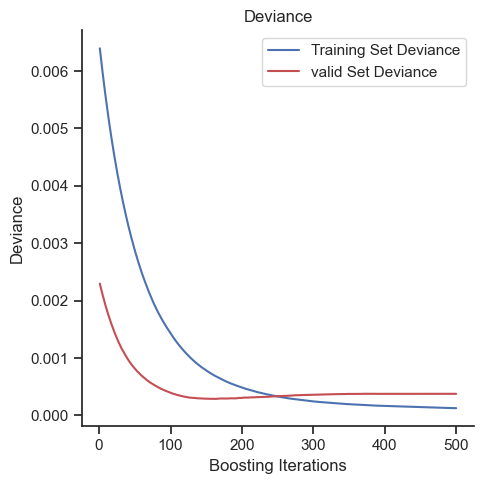

In [1222]:
valid_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_valid_std)):
    valid_score[i] = mean_squared_error(y_valid_std, y_pred)

fig = plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, valid_score, "r-", label="valid Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[ 67 134 201 268 335 402 469 536 603 671]


c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


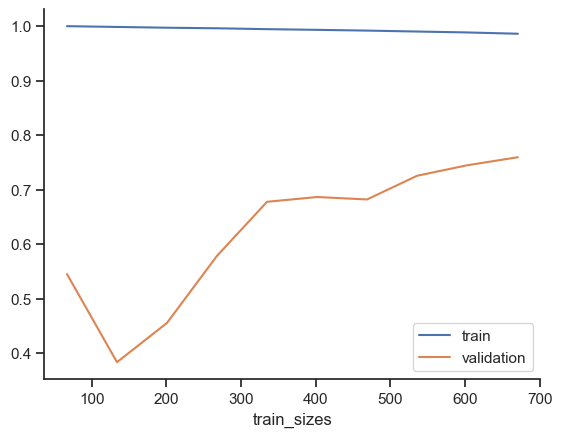

In [1223]:
from sklearn.model_selection import learning_curve
model = GradientBoostingRegressor()
N, train_score, val_score = learning_curve(model, X_train_std, y_train_std,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

<div style="background-color: pink;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">FEATURES IMPORTANCE</h3>
</div>

c:\Users\Camille B\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


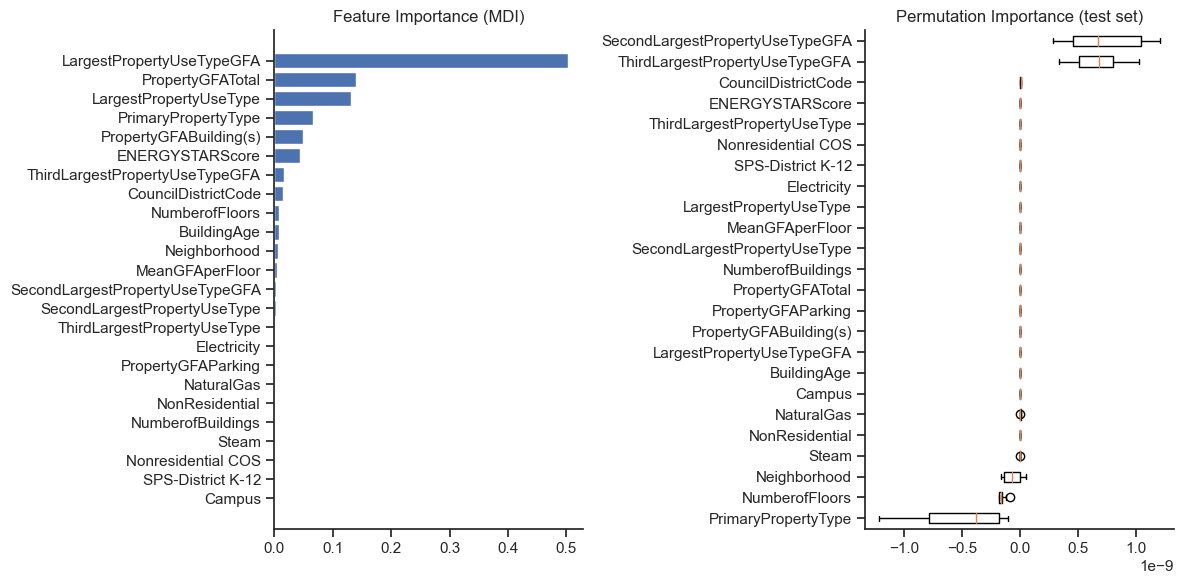

In [1224]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=20, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()